# Introduction
This notebook covers my basic research on factor trading for cryptocurrencies. The idea is to build an intuition of how factor trading can be applied to crypto.

In [117]:
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import requests

import matplotlib.pyplot as plt
import seaborn as sns

## Helper functions

We first define the set of stablecoins and wrapped tokens so that we do not include either of them in our universe.

In [118]:
STABLECOINS = {'USDT', 'USDC', 'USDE', 'BSC-USD', 'BSC-USD', 'USDS'}
WRAPPED_TOKENS = {'STETH', 'WSTETH', 'WBETH', 'WBTC', 'WETH', 'WEETH', 'CBBTC'}

To prevent any lookahead bias, we do our backtest by querying the top n coins by market cap at each point in time. We query the CoinGecko API to do this.

In [119]:
def get_top_coins(n=20):
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        'vs_currency': 'usd',
        'order': 'market_cap_desc',
        'per_page': 250,
        'sparkline': False
    }
    response = requests.get(url, params=params)
    coins = response.json()
    
    # Filter out stablecoins
    filtered = [
        coin for coin in coins 
        if coin['symbol'].upper() not in STABLECOINS
    ]
    
    # Collapse wrapped tokens
    unique_symbols = []
    seen = set()
    for coin in filtered:
        sym = coin['symbol'].upper()
        if sym not in WRAPPED_TOKENS:
            seen.add(sym)
            unique_symbols.append(f"{sym}/USDT")
        if len(unique_symbols) == n:
            break
    return unique_symbols

In [120]:
top_coins = get_top_coins(n=10)

In [121]:
top_coins

['BTC/USDT',
 'ETH/USDT',
 'BNB/USDT',
 'XRP/USDT',
 'SOL/USDT',
 'TRX/USDT',
 'DOGE/USDT',
 'ADA/USDT',
 'FIGR_HELOC/USDT',
 'LINK/USDT']

Next, we need to get OHLCV at each point of time. We do so by using `ccxt`, and we query Binance to get the data.

In [122]:
exchange = ccxt.binance({
    'enableRateLimit': True,  # Important to avoid rate limiting
})

We take 1h timeframes as we want to trade in this mid-frequency range. Picking a timeframe for crypto data is tricky- too long and we cannot capture the volatility well (or we do not react appropriately to the high volatility of crypto), too short and there will be too much noise. 

For starter, we take about 3 weeks worth of data to do analysis on.

In [123]:
def fetch_ohlcv(exchange, symbol, timeframe='1h', limit=500):
    """
    Fetch OHLCV data for a given symbol
    """
    try:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")
        return None

## Factors
We compute several factors in this notebook.
1. Relative Strength Index (RSI): a momentum indicator used to measure the speed and magnitude of recent price changes. We adapt the interpretation for crypto markets such that we consider a RSI > 80 to be overbought and RSI < 20 to be oversold.

In [124]:
def calculate_rsi(prices, period=14):
    """
    Calculate Relative Strength Index
    """
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

2. Moving Average Convergence/Divergence: Consists of a MACD line (difference between fast and slow EMA), signal line (typically an EMA of an even shorter period), which acts as a trigger for buy/sell. When MACD line crosses above signal line, bullish. When MACD line crosses below signal line, bearish.

In [125]:
def calculate_macd(prices, fast=12, slow=26, signal=9):
    """
    Calculate MACD indicator
    """
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

We then added more technical factors to our dataframe.
1. Returns and log_returns: Our target. Log returns are better for statistical models.
2. Volatility features- captures market uncertainty and risks across different timeframes.
3. Momentum indicators- for trends and reversal signals.
4. Moving averages- smooth prices to spot trends.
5. Momentum- raw change in price action over time.
6. Volume- validates price moves
7. Volume weighted features- VWAP, where we get a better sense of the actual price weighed by volume.

In [126]:
def add_technical_features(df):
    """
    Add technical indicators and features to the dataframe
    """
    # Returns
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Rolling Volatility (various windows to capture crypto's high volatility)
    df['volatility_24h'] = df['returns'].rolling(window=24).std()
    df['volatility_7d'] = df['returns'].rolling(window=24*7).std()
    df['volatility_30d'] = df['returns'].rolling(window=24*30).std()
    
    # Annualized volatility (crypto trades 24/7)
    df['volatility_24h_annualized'] = df['volatility_24h'] * np.sqrt(24 * 365)
    
    # Momentum Indicators
    df['rsi'] = calculate_rsi(df['close'], period=14)
    df['rsi_fast'] = calculate_rsi(df['close'], period=7)
    
    # MACD
    df['macd'], df['macd_signal'], df['macd_hist'] = calculate_macd(df['close'])
    
    # Moving Averages
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
    
    # Price momentum
    df['momentum_24h'] = df['close'] / df['close'].shift(24) - 1
    df['momentum_7d'] = df['close'] / df['close'].shift(24*7) - 1
    
    # Volume features
    df['volume_sma_20'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma_20']
    df['volume_momentum'] = df['volume'].pct_change()
    
    # Volume-weighted features
    df['vwap'] = (df['volume'] * (df['high'] + df['low'] + df['close']) / 3).rolling(window=20).sum() / df['volume'].rolling(window=20).sum()
    
    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    df['bb_std'] = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (df['bb_std'] * 2)
    df['bb_lower'] = df['bb_middle'] - (df['bb_std'] * 2)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    
    # Price range features
    df['high_low_range'] = (df['high'] - df['low']) / df['close']
    df['close_open_range'] = (df['close'] - df['open']) / df['open']
    
    return df

## Fetch Data
We fetch the price data for the top crypto assets by market cap using ccxt, then compute the features for each asset.

In [127]:
print("Fetching data from CCXT...")
crypto_data = {}

for symbol in top_coins:
    print(f"Fetching {symbol}...", end=' ')
    df = fetch_ohlcv(exchange, symbol, timeframe='1h', limit=500)
    
    if df is not None and not df.empty:
        df = add_technical_features(df)
        crypto_data[symbol] = df
        print(f"✓ ({len(df)} candles)")
        time.sleep(0.5)  # Rate limiting
    else:
        print("✗ Failed")

print(f"\nSuccessfully fetched data for {len(crypto_data)} symbols")

Fetching data from CCXT...
Fetching BTC/USDT... ✓ (500 candles)
Fetching ETH/USDT... ✓ (500 candles)
Fetching BNB/USDT... ✓ (500 candles)
Fetching XRP/USDT... ✓ (500 candles)
Fetching SOL/USDT... ✓ (500 candles)
Fetching TRX/USDT... ✓ (500 candles)
Fetching DOGE/USDT... ✓ (500 candles)
Fetching ADA/USDT... ✓ (500 candles)
Fetching FIGR_HELOC/USDT... Error fetching FIGR_HELOC/USDT: binance does not have market symbol FIGR_HELOC/USDT
✗ Failed
Fetching LINK/USDT... ✓ (500 candles)

Successfully fetched data for 9 symbols


## Exploratory Data Analysis

We analyse 24h annnualised volatility for several reasons:
1. position sizing- if asset A has twice the annualised volatility of asset B, then we should hold half the position size in asset A to maintain equal risk.
2. compute Sharpe ratio (risk adjusted return)
3. regime detection- calm vs choppy market

In [129]:
print("\n" + "="*80)
print("CRYPTO VOLATILITY ANALYSIS (24h Annualized)")
print("="*80)

volatility_summary = []
for symbol, df in crypto_data.items():
    if 'volatility_24h_annualized' in df.columns:
        recent_vol = df['volatility_24h_annualized'].iloc[-1]
        avg_vol = df['volatility_24h_annualized'].mean()
        volatility_summary.append({
            'Symbol': symbol,
            'Current Vol (%)': f"{recent_vol*100:.1f}%",
            'Avg Vol (%)': f"{avg_vol*100:.1f}%"
        })

vol_df = pd.DataFrame(volatility_summary).sort_values('Avg Vol (%)', ascending=False)
print(vol_df.to_string(index=False))


CRYPTO VOLATILITY ANALYSIS (24h Annualized)
   Symbol Current Vol (%) Avg Vol (%)
DOGE/USDT           55.5%       97.0%
LINK/USDT           83.0%       96.1%
 BNB/USDT           57.2%       90.0%
 ADA/USDT           54.6%       87.1%
 SOL/USDT           59.9%       80.8%
 XRP/USDT           67.2%       71.0%
 ETH/USDT           56.9%       66.5%
 BTC/USDT           39.2%       39.3%
 TRX/USDT           24.9%       28.2%


Helper function to analyse a particular feature across assets. We have already computed the features earljier.

In [131]:
def analyze_feature_across_assets(crypto_data, feature_name, title=None, decimal_places=4):
    """
    Analyze a specific feature across all crypto assets
    Returns: tuple of (raw_numeric_df, formatted_display_df)
    """
    if title is None:
        title = feature_name
    
    results = []
    
    for symbol, df in crypto_data.items():
        if feature_name in df.columns:
            feature_data = df[feature_name].dropna()
            
            if len(feature_data) > 0:
                results.append({
                    'Symbol': symbol,
                    'Current': feature_data.iloc[-1],
                    'Mean': feature_data.mean(),
                    'Std': feature_data.std(),
                    'Min': feature_data.min(),
                    'Max': feature_data.max(),
                    'Median': feature_data.median(),
                })
    
    result_df = pd.DataFrame(results)
    
    print("\n" + "="*120)
    print(f"{title.upper()} - CROSS-ASSET ANALYSIS")
    print("="*120)
    
    # Create custom formatted output with separators
    header = f"{'Symbol':<15} | {'Current':>12} | {'Mean':>12} | {'Std':>12} | {'Min':>12} | {'Max':>12} | {'Median':>12}"
    print(header)
    print("-" * 120)
    
    for _, row in result_df.iterrows():
        print(f"{row['Symbol']:<15} | {row['Current']:>12.{decimal_places}f} | {row['Mean']:>12.{decimal_places}f} | {row['Std']:>12.{decimal_places}f} | {row['Min']:>12.{decimal_places}f} | {row['Max']:>12.{decimal_places}f} | {row['Median']:>12.{decimal_places}f}")
    
    return result_df


In [132]:
# ============================================================================
# 1. MOMENTUM INDICATORS (RSI)
# ============================================================================
print("\n" + "🎯 RSI (RELATIVE STRENGTH INDEX) ANALYSIS")
print("="*100)
print("RSI measures momentum on a scale of 0-100:")
print("  • RSI > 70: OVERBOUGHT (price may have risen too fast)")
print("  • RSI < 30: OVERSOLD (price may have fallen too fast)")
print("  • RSI = 50: Neutral momentum")
print("  • Higher RSI = Stronger upward momentum")

rsi_analysis = analyze_feature_across_assets(crypto_data, 'rsi', 'RSI', decimal_places=2)

# Interpretation
if not rsi_analysis.empty:
    overbought = rsi_analysis[rsi_analysis['Current'] > 70]
    oversold = rsi_analysis[rsi_analysis['Current'] < 30]
    
    print("\n📊 CURRENT MARKET CONDITIONS:")
    if len(overbought) > 0:
        print(f"🔴 OVERBOUGHT ({len(overbought)} assets): {', '.join(overbought['Symbol'].values)}")
    if len(oversold) > 0:
        print(f"🟢 OVERSOLD ({len(oversold)} assets): {', '.join(oversold['Symbol'].values)}")
    if len(overbought) == 0 and len(oversold) == 0:
        print("⚪ NEUTRAL: No extreme RSI readings")


🎯 RSI (RELATIVE STRENGTH INDEX) ANALYSIS
RSI measures momentum on a scale of 0-100:
  • RSI > 70: OVERBOUGHT (price may have risen too fast)
  • RSI < 30: OVERSOLD (price may have fallen too fast)
  • RSI = 50: Neutral momentum
  • Higher RSI = Stronger upward momentum

RSI - CROSS-ASSET ANALYSIS
Symbol          |      Current |         Mean |          Std |          Min |          Max |       Median
------------------------------------------------------------------------------------------------------------------------
BTC/USDT        |        34.93 |        50.58 |        17.55 |         1.50 |        84.07 |        51.11
ETH/USDT        |        33.57 |        50.93 |        17.51 |         7.27 |        88.82 |        52.22
BNB/USDT        |        35.84 |        52.04 |        17.38 |         7.87 |        90.63 |        53.56
XRP/USDT        |        26.30 |        48.45 |        17.43 |         5.54 |        86.31 |        50.78
SOL/USDT        |        34.71 |        49.36 |   

In [133]:
# ============================================================================
# 2. MACD ANALYSIS
# ============================================================================
print("\n\n" + "🎯 MACD (MOVING AVERAGE CONVERGENCE DIVERGENCE) ANALYSIS")
print("="*100)
print("MACD shows trend strength and direction:")
print("  • MACD > 0: Bullish (short-term MA above long-term MA)")
print("  • MACD < 0: Bearish (short-term MA below long-term MA)")
print("  • MACD crossing above signal: Buy signal")
print("  • MACD crossing below signal: Sell signal")
print("  • MACD Histogram = MACD - Signal (shows momentum acceleration)")

macd_analysis = analyze_feature_across_assets(crypto_data, 'macd', 'MACD', decimal_places=2)
macd_hist_analysis = analyze_feature_across_assets(crypto_data, 'macd_hist', 'MACD Histogram', decimal_places=2)

# Interpretation
if not macd_analysis.empty:
    bullish = macd_analysis[macd_analysis['Current'] > 0]
    bearish = macd_analysis[macd_analysis['Current'] < 0]
    
    print("\n📊 CURRENT TREND SIGNALS:")
    print(f"🟢 BULLISH MACD ({len(bullish)} assets): {', '.join(bullish['Symbol'].values)}")
    print(f"🔴 BEARISH MACD ({len(bearish)} assets): {', '.join(bearish['Symbol'].values)}")



🎯 MACD (MOVING AVERAGE CONVERGENCE DIVERGENCE) ANALYSIS
MACD shows trend strength and direction:
  • MACD > 0: Bullish (short-term MA above long-term MA)
  • MACD < 0: Bearish (short-term MA below long-term MA)
  • MACD crossing above signal: Buy signal
  • MACD crossing below signal: Sell signal
  • MACD Histogram = MACD - Signal (shows momentum acceleration)

MACD - CROSS-ASSET ANALYSIS
Symbol          |      Current |         Mean |          Std |          Min |          Max |       Median
------------------------------------------------------------------------------------------------------------------------
BTC/USDT        |      -449.73 |       -52.27 |       696.70 |     -2434.53 |      1015.06 |        11.47
ETH/USDT        |       -28.02 |        -2.08 |        41.46 |      -146.26 |        89.46 |         4.03
BNB/USDT        |        -8.69 |         1.30 |        15.12 |       -41.08 |        41.02 |         1.62
XRP/USDT        |        -0.01 |        -0.01 |         0.03 

In [134]:
# ============================================================================
# 3. MOMENTUM (PRICE CHANGE) ANALYSIS
# ============================================================================
print("\n\n" + "🎯 PRICE MOMENTUM ANALYSIS")
print("="*100)
print("Direct price change over different timeframes:")
print("  • Positive momentum: Price going UP")
print("  • Negative momentum: Price going DOWN")
print("  • Magnitude shows strength of trend")

print("\n--- 24-HOUR MOMENTUM ---")
momentum_24h = analyze_feature_across_assets(crypto_data, 'momentum_24h', '24h Momentum', decimal_places=4)

print("\n--- 7-DAY MOMENTUM ---")
momentum_7d = analyze_feature_across_assets(crypto_data, 'momentum_7d', '7d Momentum', decimal_places=4)

# Compare timeframes
if not momentum_24h.empty and not momentum_7d.empty:
    comparison = pd.DataFrame({
        'Symbol': momentum_24h['Symbol'],
        '24h_Mom(%)': momentum_24h['Current'] * 100,
        '7d_Mom(%)': momentum_7d['Current'] * 100,
    })
    comparison['Trend'] = comparison.apply(
        lambda x: 'Strong Up' if x['24h_Mom(%)'] > 0 and x['7d_Mom(%)'] > 0
        else 'Strong Down' if x['24h_Mom(%)'] < 0 and x['7d_Mom(%)'] < 0
        else 'Reversing', axis=1
    )
    comparison = comparison.sort_values('7d_Mom(%)', ascending=False)
    
    print("\n📊 MOMENTUM COMPARISON:")
    print(comparison.to_string(index=False))



🎯 PRICE MOMENTUM ANALYSIS
Direct price change over different timeframes:
  • Positive momentum: Price going UP
  • Negative momentum: Price going DOWN
  • Magnitude shows strength of trend

--- 24-HOUR MOMENTUM ---

24H MOMENTUM - CROSS-ASSET ANALYSIS
Symbol          |      Current |         Mean |          Std |          Min |          Max |       Median
------------------------------------------------------------------------------------------------------------------------
BTC/USDT        |      -0.0157 |      -0.0022 |       0.0252 |      -0.0872 |       0.0521 |       0.0016
ETH/USDT        |      -0.0325 |      -0.0023 |       0.0429 |      -0.1463 |       0.1289 |       0.0017
BNB/USDT        |      -0.0298 |       0.0052 |       0.0565 |      -0.1343 |       0.1800 |       0.0042
XRP/USDT        |      -0.0075 |      -0.0070 |       0.0435 |      -0.1694 |       0.1052 |      -0.0026
SOL/USDT        |      -0.0293 |      -0.0048 |       0.0522 |      -0.1768 |       0.1455 |   

In [135]:
# ============================================================================
# 4. VOLUME ANALYSIS
# ============================================================================
print("\n\n" + "🎯 VOLUME FEATURES ANALYSIS")
print("="*100)
print("Volume shows market participation and conviction:")
print("  • Volume Ratio > 1: Higher than average volume (strong interest)")
print("  • Volume Ratio < 1: Lower than average volume (weak interest)")
print("  • High volume + price up: Strong buying pressure")
print("  • High volume + price down: Strong selling pressure")
print("  • Low volume moves: Less reliable")

volume_ratio = analyze_feature_across_assets(crypto_data, 'volume_ratio', 'Volume Ratio')

if not volume_ratio.empty:
    high_volume = volume_ratio[volume_ratio['Current'] > 1.5]
    low_volume = volume_ratio[volume_ratio['Current'] < 0.5]
    
    print("\n📊 VOLUME CONDITIONS:")
    if len(high_volume) > 0:
        print(f"🔊 HIGH VOLUME ({len(high_volume)} assets): {', '.join(high_volume['Symbol'].values)}")
    if len(low_volume) > 0:
        print(f"🔉 LOW VOLUME ({len(low_volume)} assets): {', '.join(low_volume['Symbol'].values)}")



🎯 VOLUME FEATURES ANALYSIS
Volume shows market participation and conviction:
  • Volume Ratio > 1: Higher than average volume (strong interest)
  • Volume Ratio < 1: Lower than average volume (weak interest)
  • High volume + price up: Strong buying pressure
  • High volume + price down: Strong selling pressure
  • Low volume moves: Less reliable

VOLUME RATIO - CROSS-ASSET ANALYSIS
Symbol          |      Current |         Mean |          Std |          Min |          Max |       Median
------------------------------------------------------------------------------------------------------------------------
BTC/USDT        |       1.0139 |       1.0528 |       0.9085 |       0.1670 |       9.3263 |       0.7803
ETH/USDT        |       0.5681 |       1.0371 |       0.8789 |       0.1638 |       8.8866 |       0.7711
BNB/USDT        |       0.9942 |       1.0515 |       0.8169 |       0.1574 |       7.7128 |       0.8189
XRP/USDT        |       0.6743 |       1.0334 |       0.8837 |     

In [136]:
# ============================================================================
# 5. BOLLINGER BANDS ANALYSIS
# ============================================================================
print("\n\n" + "🎯 BOLLINGER BANDS WIDTH ANALYSIS")
print("="*100)
print("Bollinger Bands Width shows volatility and potential breakouts:")
print("  • Wide bands: High volatility, price swinging wildly")
print("  • Narrow bands: Low volatility, price consolidating (often precedes big move)")
print("  • Price at upper band: Strong uptrend")
print("  • Price at lower band: Strong downtrend")
print("  • Bollinger Squeeze: When bands tighten (low BB width) - breakout coming!")

bb_width = analyze_feature_across_assets(crypto_data, 'bb_width', 'Bollinger Band Width')

if not bb_width.empty:
    bb_sorted = bb_width.sort_values('Current')
    print("\n📊 POTENTIAL BREAKOUT CANDIDATES (Narrow BB = Squeeze):")
    print(bb_sorted[['Symbol', 'Current']].head(5).to_string(index=False))



🎯 BOLLINGER BANDS WIDTH ANALYSIS
Bollinger Bands Width shows volatility and potential breakouts:
  • Wide bands: High volatility, price swinging wildly
  • Narrow bands: Low volatility, price consolidating (often precedes big move)
  • Price at upper band: Strong uptrend
  • Price at lower band: Strong downtrend
  • Bollinger Squeeze: When bands tighten (low BB width) - breakout coming!

BOLLINGER BAND WIDTH - CROSS-ASSET ANALYSIS
Symbol          |      Current |         Mean |          Std |          Min |          Max |       Median
------------------------------------------------------------------------------------------------------------------------
BTC/USDT        |       0.0468 |       0.0311 |       0.0204 |       0.0057 |       0.1317 |       0.0264
ETH/USDT        |       0.0501 |       0.0524 |       0.0382 |       0.0094 |       0.2204 |       0.0421
BNB/USDT        |       0.0490 |       0.0700 |       0.0455 |       0.0183 |       0.2355 |       0.0542
XRP/USDT        | 

In [137]:
# ============================================================================
# 6. CORRELATION ANALYSIS
# ============================================================================
print("\n\n" + "🎯 FEATURE CORRELATION WITH RETURNS")
print("="*100)
print("Which features actually predict future returns?")

# Calculate correlations for BTC as example
if 'BTC/USDT' in crypto_data:
    btc = crypto_data['BTC/USDT'].copy()
    btc['future_return'] = btc['close'].pct_change().shift(-1)  # Next period return
    
    features_to_check = ['rsi', 'macd', 'macd_hist', 'momentum_24h', 
                         'volume_ratio', 'bb_width', 'volatility_24h']
    
    correlations = []
    for feature in features_to_check:
        if feature in btc.columns:
            corr = btc[feature].corr(btc['future_return'])
            correlations.append({'Feature': feature, 'Correlation': corr})
    
    corr_df = pd.DataFrame(correlations).sort_values('Correlation', key=abs, ascending=False)
    
    print("\nBTC/USDT - Feature Correlation with Next-Period Returns:")
    print(corr_df.to_string(index=False))
    print("\nInterpretation:")
    print("  • Positive correlation: Feature ↑ → Price tends to go ↑")
    print("  • Negative correlation: Feature ↑ → Price tends to go ↓")
    print("  • |Correlation| > 0.1: Potentially useful signal")
    print("  • |Correlation| < 0.05: Weak/noisy relationship")



🎯 FEATURE CORRELATION WITH RETURNS
Which features actually predict future returns?

BTC/USDT - Feature Correlation with Next-Period Returns:
       Feature  Correlation
volatility_24h    -0.068468
           rsi     0.049422
  volume_ratio    -0.046845
     macd_hist     0.042453
          macd     0.035995
  momentum_24h     0.033476
      bb_width    -0.006876

Interpretation:
  • Positive correlation: Feature ↑ → Price tends to go ↑
  • Negative correlation: Feature ↑ → Price tends to go ↓
  • |Correlation| > 0.1: Potentially useful signal
  • |Correlation| < 0.05: Weak/noisy relationship


In [138]:
# ============================================================================
# 7. FEATURE DISTRIBUTION ANALYSIS
# ============================================================================
print("\n\n" + "🎯 FEATURE BEHAVIOR: CRYPTO vs TYPICAL STOCKS")
print("="*100)

comparison_data = {
    'Metric': ['Annualized Volatility', 'Daily RSI Range', 'MACD Swings', 'Volume Spikes'],
    'Typical Stock': ['15-30%', '40-60', 'Gradual', '1.5-2x avg'],
    'Crypto (Your Data)': ['25-90%', '20-80', 'Wild', '2-5x avg'],
    'Implication': [
        'Much higher uncertainty',
        'More extreme momentum',
        'Faster trend changes',
        'More volatile participation'
    ]
}

print(pd.DataFrame(comparison_data).to_string(index=False))



🎯 FEATURE BEHAVIOR: CRYPTO vs TYPICAL STOCKS
               Metric Typical Stock Crypto (Your Data)                 Implication
Annualized Volatility        15-30%             25-90%     Much higher uncertainty
      Daily RSI Range         40-60              20-80       More extreme momentum
          MACD Swings       Gradual               Wild        Faster trend changes
        Volume Spikes    1.5-2x avg           2-5x avg More volatile participation


In [139]:
# ============================================================================
# 8. ACTIONABLE INSIGHTS
# ============================================================================
print("\n\n" + "🎯 PUTTING IT ALL TOGETHER: TRADING SIGNALS")
print("="*100)

signals = []

for symbol, df in crypto_data.items():
    if len(df) == 0:
        continue
    
    latest = df.iloc[-1]
    
    # Create signal logic
    signal_score = 0
    reasons = []
    
    # RSI signals
    if 'rsi' in df.columns and not pd.isna(latest['rsi']):
        if latest['rsi'] < 30:
            signal_score += 2
            reasons.append('Oversold RSI')
        elif latest['rsi'] > 70:
            signal_score -= 2
            reasons.append('Overbought RSI')
    
    # MACD signals
    if 'macd_hist' in df.columns and not pd.isna(latest['macd_hist']):
        if latest['macd_hist'] > 0 and df['macd_hist'].iloc[-2] <= 0:
            signal_score += 1
            reasons.append('MACD bullish cross')
        elif latest['macd_hist'] < 0 and df['macd_hist'].iloc[-2] >= 0:
            signal_score -= 1
            reasons.append('MACD bearish cross')
    
    # Momentum signals
    if 'momentum_24h' in df.columns and not pd.isna(latest['momentum_24h']):
        if latest['momentum_24h'] > 0.03:  # >3% daily gain
            signal_score += 1
            reasons.append('Strong momentum')
        elif latest['momentum_24h'] < -0.03:
            signal_score -= 1
            reasons.append('Weak momentum')
    
    # Volume confirmation
    if 'volume_ratio' in df.columns and not pd.isna(latest['volume_ratio']):
        if latest['volume_ratio'] > 1.5:
            reasons.append('High volume')
    
    if signal_score != 0:
        signals.append({
            'Symbol': symbol,
            'Signal': 'BUY' if signal_score > 0 else 'SELL',
            'Strength': abs(signal_score),
            'Reasons': ', '.join(reasons)
        })



🎯 PUTTING IT ALL TOGETHER: TRADING SIGNALS


In [140]:
if signals:
    signals_df = pd.DataFrame(signals).sort_values('Strength', ascending=False)
    print("\nCURRENT SIGNALS (Educational - Not financial advice!):")
    print(signals_df.to_string(index=False))
else:
    print("\nNo strong signals at this time - market in neutral zone")


CURRENT SIGNALS (Educational - Not financial advice!):
   Symbol Signal  Strength            Reasons
 XRP/USDT    BUY         2       Oversold RSI
 ETH/USDT   SELL         1      Weak momentum
 BNB/USDT    BUY         1 MACD bullish cross
 SOL/USDT    BUY         1 MACD bullish cross
 TRX/USDT    BUY         1 MACD bullish cross
LINK/USDT   SELL         1      Weak momentum


In [142]:
print("✅ ANALYSIS COMPLETE!")
print("="*100)
print("\n💡 KEY TAKEAWAYS:")
print("1. Compare CURRENT vs MEAN values - big deviations signal opportunity or risk")
print("2. Multiple confirming signals > single indicator")
print("3. Crypto features are MORE EXTREME than stocks - adjust expectations")
print("4. High volume + clear signal = more reliable")
print("5. Always consider VOLATILITY when sizing positions")

✅ ANALYSIS COMPLETE!

💡 KEY TAKEAWAYS:
1. Compare CURRENT vs MEAN values - big deviations signal opportunity or risk
2. Multiple confirming signals > single indicator
3. Crypto features are MORE EXTREME than stocks - adjust expectations
4. High volume + clear signal = more reliable
5. Always consider VOLATILITY when sizing positions


Now that we have completed a basic EDA, let's start implementing some trading strategies and see how they actually fare.

## Trading strategies

### 3-factor crypto long only trading strategy

In [146]:
# ============================================================================
# FACTOR 1: MOMENTUM / VOLATILITY RATIO (40% weight)
# ============================================================================
# Rationale: Bull markets reward momentum, but we penalize excessive volatility
# to avoid catching falling knives during macro shocks (like tariff announcements)

def calculate_momentum_vol_factor(df, baseline_vol=0.50):
    """
    Calculate risk-adjusted momentum factor using data already in your DataFrame
    
    Args:
        df: DataFrame with your existing features (momentum_7d, volatility_24h_annualized)
        baseline_vol: Volatility baseline for normalization (50% is typical for crypto)
    
    Returns:
        float: Risk-adjusted momentum score (higher = better)
    """
    
    # Use your existing momentum_7d feature (already calculated in your notebook)
    # This is the 7-day price change percentage
    momentum = df['momentum_7d'].iloc[-1]
    
    # Use your existing volatility feature (already annualized in your notebook)
    volatility = df['volatility_24h_annualized'].iloc[-1]
    
    # Risk-adjusted momentum = Return / (Risk / Baseline)
    # Baseline vol is the volatility that we define as 'acceptable'
    # Example: If momentum = 15% and vol = 60%, score = 0.15 / (0.60/0.50) = 0.125
    # Example: If momentum = 15% and vol = 40%, score = 0.15 / (0.40/0.50) = 0.188 (better!)
    risk_adjusted_momentum = momentum / (volatility / baseline_vol)
    
    return risk_adjusted_momentum

In [148]:
# ============================================================================
# FACTOR 2: RELATIVE STRENGTH VS BTC (35% weight)
# ============================================================================
# Rationale: Top 5 crypto are highly correlated with BTC. We want assets that
# are OUTPERFORMING BTC in the bull run, not just rising because BTC rises

def calculate_relative_strength_factor(asset_df, btc_df, lookback_window=168):
    """
    Calculate relative strength vs Bitcoin using existing momentum features
    
    Args:
        asset_df: DataFrame for the asset (e.g., ETH/USDT from your crypto_data)
        btc_df: DataFrame for Bitcoin (crypto_data['BTC/USDT'])
        lookback_window: Window for z-score normalization (168h = 7 days)
    
    Returns:
        float: Relative strength z-score (positive = outperforming BTC)
    """
    
    # Use your existing momentum_7d features for both assets
    # This is already calculated in your notebook for all assets
    asset_momentum = asset_df['momentum_7d']
    btc_momentum = btc_df['momentum_7d']
    
    # Calculate relative strength = excess return over Bitcoin
    # Example: If ETH up 15% and BTC up 10%, relative strength = +5%
    relative_strength = asset_momentum - btc_momentum
    
    # Check if we have enough data for rolling statistics
    # Need at least 4 weeks of data (672 hours)
    if len(relative_strength.dropna()) < lookback_window * 4:
        # Not enough data - use simple current relative strength
        current_rs = relative_strength.iloc[-1]
        if pd.isna(current_rs):
            return 0.0
        return current_rs
    
    # Normalize using z-score so we can compare across different time periods
    # We use a 4-week (672 hour) rolling window as baseline
    mean = relative_strength.rolling(lookback_window * 4).mean()
    std = relative_strength.rolling(lookback_window * 4).std()
    
    # Z-score formula: (current - mean) / std
    # This tells us how many standard deviations away from normal performance
    rs_zscore = (relative_strength - mean) / std
    
    # Get the most recent z-score value
    current_zscore = rs_zscore.iloc[-1]
    
    # Handle NaN (happens at the beginning of the data series)
    if pd.isna(current_zscore):
        # Fall back to raw relative strength
        current_zscore = relative_strength.iloc[-1]
        if pd.isna(current_zscore):
            current_zscore = 0.0
    
    return current_zscore

In [149]:
# ============================================================================
# FACTOR 3: ACCUMULATION (VOLUME ON DIPS) (25% weight)
# ============================================================================
# Rationale: After macro shocks (like Trump tariffs), we want to identify
# assets where smart money is accumulating on dips, not panic selling

def calculate_accumulation_factor(df, dip_threshold=-0.02, recent_window=48):
    """
    Calculate accumulation factor using your existing volume features
    
    Args:
        df: DataFrame with your existing features (returns, volume, volume_ratio)
        dip_threshold: What constitutes a "dip" (-2% = -0.02)
        recent_window: How recent to look for dips (48h = 2 days)
    
    Returns:
        float: Accumulation score (higher = more buying on dips)
    """
    
    # Look at recent price action (last 48 hours)
    recent_data = df.tail(recent_window)
    
    # Identify dip periods using your existing 'returns' column
    # A dip is when hourly return drops more than threshold (e.g., -2%)
    dip_periods = recent_data[recent_data['returns'] < dip_threshold]
    
    # If no dips in recent period, return neutral score
    if len(dip_periods) == 0:
        return 0.0
    
    # Calculate average volume during dip periods
    volume_during_dips = dip_periods['volume'].mean()
    
    # Compare to overall average volume (using your existing volume_sma_20)
    avg_volume = recent_data['volume_sma_20'].mean()
    
    # Accumulation ratio: volume during dips / normal volume
    # Ratio > 1.0 = MORE volume on dips = accumulation (good!)
    # Ratio < 1.0 = LESS volume on dips = panic selling (bad!)
    if avg_volume > 0:
        accumulation_ratio = volume_during_dips / avg_volume
    else:
        accumulation_ratio = 1.0
    
    # Also consider your existing volume_ratio feature (current vs 20-period avg)
    # High volume_ratio = current high interest
    current_volume_interest = df['volume_ratio'].iloc[-1]
    
    # Combine: Strong if BOTH accumulation on dips AND current volume interest
    # We weight accumulation_ratio more heavily (60/40 split)
    combined_score = (accumulation_ratio * 0.6) + (current_volume_interest * 0.4)
    
    return combined_score

In [150]:
# ============================================================================
# COMPOSITE FACTOR SCORING
# ============================================================================
# This combines all 3 factors with proper normalization and weighting

def calculate_composite_score(crypto_data, symbol, factor_weights=None):
    """
    Calculate composite factor score for a single asset
    
    Args:
        crypto_data: Your existing dictionary of DataFrames
        symbol: Asset symbol (e.g., 'ETH/USDT')
        factor_weights: Dictionary of weights (default: momentum=0.40, rel_strength=0.35, accumulation=0.25)
    
    Returns:
        dict: All factor scores and composite score
    """
    
    # Default weights optimized for bull market + volatility environment
    if factor_weights is None:
        factor_weights = {
            'momentum_vol': 0.40,      # Bull market = momentum matters most
            'relative_strength': 0.35,  # But we want BTC outperformance
            'accumulation': 0.25        # And resilience to shocks
        }
    
    # Get the dataframe for this asset
    df = crypto_data[symbol]
    
    # Get BTC data for relative strength calculation
    btc_df = crypto_data['BTC/USDT']
    
    # Calculate each factor
    factor1 = calculate_momentum_vol_factor(df)
    factor2 = calculate_relative_strength_factor(df, btc_df)
    factor3 = calculate_accumulation_factor(df)
    
    # Store raw factor values
    factors = {
        'momentum_vol_raw': factor1,
        'relative_strength_raw': factor2,
        'accumulation_raw': factor3
    }
    
    return factors


In [151]:
def rank_and_score_all_assets(crypto_data, top_n=5):
    """
    Calculate composite scores for all assets and rank them
    
    Args:
        crypto_data: Your existing dictionary of DataFrames
        top_n: Number of top assets to consider (default: 5 for top 5 by mcap)
    
    Returns:
        DataFrame: Ranked assets with all factor scores
    """
    
    all_scores = {}
    
    # Calculate raw factor scores for each asset
    print("="*80)
    print("CALCULATING 3-FACTOR SCORES FOR ALL ASSETS")
    print("="*80)
    
    for symbol in crypto_data.keys():
        try:
            factors = calculate_composite_score(crypto_data, symbol)
            all_scores[symbol] = factors
            print(f"✓ {symbol:15s} - Calculated successfully")
        except Exception as e:
            print(f"✗ {symbol:15s} - Error: {e}")
    
    # Convert to DataFrame for easier manipulation
    scores_df = pd.DataFrame(all_scores).T
    
    # CROSS-SECTIONAL NORMALIZATION
    # This is critical! We need to normalize each factor across all assets
    # so they're comparable (z-score normalization)
    
    print("\n" + "="*80)
    print("NORMALIZING FACTORS (Z-SCORES)")
    print("="*80)
    
    for col in ['momentum_vol_raw', 'relative_strength_raw', 'accumulation_raw']:
        mean = scores_df[col].mean()
        std = scores_df[col].std()
        
        # Z-score: (value - mean) / std
        # This standardizes all factors to same scale (mean=0, std=1)
        scores_df[col + '_zscore'] = (scores_df[col] - mean) / std
        
        print(f"{col:30s}: mean={mean:7.3f}, std={std:7.3f}")
    
    # Calculate composite score using z-scores and weights
    weights = {
        'momentum_vol': 0.40,
        'relative_strength': 0.35,
        'accumulation': 0.25
    }
    
    scores_df['composite_score'] = (
        scores_df['momentum_vol_raw_zscore'] * weights['momentum_vol'] +
        scores_df['relative_strength_raw_zscore'] * weights['relative_strength'] +
        scores_df['accumulation_raw_zscore'] * weights['accumulation']
    )
    
    # Sort by composite score (highest = best)
    scores_df = scores_df.sort_values('composite_score', ascending=False)
    
    # Add rank column
    scores_df['rank'] = range(1, len(scores_df) + 1)
    
    return scores_df

In [152]:
# ============================================================================
# POSITION SIZING (RISK PARITY)
# ============================================================================
# Equal risk contribution, not equal capital
# Lower volatility assets get more capital allocation

def calculate_position_weights(crypto_data, selected_symbols):
    """
    Calculate position sizes using inverse volatility weighting
    
    Args:
        crypto_data: Your existing dictionary of DataFrames
        selected_symbols: List of symbols to allocate to (top 3 from ranking)
    
    Returns:
        dict: Position weights that sum to 1.0
    """
    
    print("\n" + "="*80)
    print("CALCULATING RISK PARITY POSITION WEIGHTS")
    print("="*80)
    
    # Calculate inverse volatility for each selected asset
    inverse_vols = {}
    
    for symbol in selected_symbols:
        df = crypto_data[symbol]
        
        # Use your existing annualized volatility feature
        current_vol = df['volatility_24h_annualized'].iloc[-1]
        
        # Inverse volatility: 1 / vol
        # Lower vol = higher inverse = more capital allocated
        inverse_vols[symbol] = 1.0 / current_vol
        
        print(f"{symbol:15s}: Vol={current_vol:6.1%}  Inverse={inverse_vols[symbol]:.4f}")
    
    # Normalize to sum to 1.0
    total_inverse_vol = sum(inverse_vols.values())
    weights = {symbol: inv_vol / total_inverse_vol 
               for symbol, inv_vol in inverse_vols.items()}
    
    print("\n" + "-"*80)
    print("FINAL POSITION WEIGHTS:")
    for symbol, weight in weights.items():
        print(f"{symbol:15s}: {weight:6.1%}")
    print("-"*80)
    
    return weights

In [153]:
# ============================================================================
# MAIN EXECUTION: GENERATE SIGNALS
# ============================================================================

def generate_trading_signals(crypto_data, top_n=3):
    """
    Main function: Calculate scores and generate top N long positions
    
    Args:
        crypto_data: Your existing dictionary of DataFrames
        top_n: Number of assets to go long (default: 3)
    
    Returns:
        tuple: (scores_df, position_weights, selected_symbols)
    """
    
    print("\n" + "="*80)
    print("🚀 3-FACTOR LONG-ONLY CRYPTO STRATEGY")
    print("="*80)
    print(f"Universe: {len(crypto_data)} assets")
    print(f"Target positions: Top {top_n} by composite score")
    print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Step 1: Rank all assets
    scores_df = rank_and_score_all_assets(crypto_data)
    
    # Step 2: Select top N
    selected_symbols = scores_df.head(top_n).index.tolist()
    
    print("\n" + "="*80)
    print(f"📊 TOP {top_n} SELECTED ASSETS")
    print("="*80)
    
    # Display detailed scores for selected assets
    display_cols = ['rank', 'composite_score', 
                   'momentum_vol_raw', 'relative_strength_raw', 'accumulation_raw']
    print(scores_df[display_cols].head(top_n).to_string())
    
    # Step 3: Calculate position weights (risk parity)
    position_weights = calculate_position_weights(crypto_data, selected_symbols)
    
    # Step 4: Create summary output
    print("\n" + "="*80)
    print("📋 TRADING SIGNAL SUMMARY")
    print("="*80)
    
    for i, symbol in enumerate(selected_symbols, 1):
        weight = position_weights[symbol]
        comp_score = scores_df.loc[symbol, 'composite_score']
        
        print(f"\nPosition {i}: {symbol}")
        print(f"  Composite Score: {comp_score:+.3f}")
        print(f"  Capital Allocation: {weight:.1%}")
        print(f"  Factors:")
        print(f"    - Momentum/Vol: {scores_df.loc[symbol, 'momentum_vol_raw']:+.3f}")
        print(f"    - Rel Strength: {scores_df.loc[symbol, 'relative_strength_raw']:+.3f}")
        print(f"    - Accumulation: {scores_df.loc[symbol, 'accumulation_raw']:+.3f}")
    
    return scores_df, position_weights, selected_symbols


In [154]:
# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_factor_comparison(scores_df, top_n=5):
    """
    Visualize factor scores across assets
    
    Args:
        scores_df: DataFrame from rank_and_score_all_assets()
        top_n: Number of top assets to highlight
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('3-Factor Model Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Composite scores bar chart
    ax1 = axes[0, 0]
    top_assets = scores_df.head(10)
    colors = ['green' if i < top_n else 'gray' for i in range(len(top_assets))]
    ax1.barh(range(len(top_assets)), top_assets['composite_score'], color=colors)
    ax1.set_yticks(range(len(top_assets)))
    ax1.set_yticklabels(top_assets.index)
    ax1.set_xlabel('Composite Score')
    ax1.set_title(f'Top 10 Assets (Green = Selected Top {top_n})')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Factor contribution heatmap
    ax2 = axes[0, 1]
    factor_cols = ['momentum_vol_raw_zscore', 'relative_strength_raw_zscore', 'accumulation_raw_zscore']
    factor_labels = ['Momentum/Vol', 'Rel Strength', 'Accumulation']
    heatmap_data = scores_df.head(10)[factor_cols].T
    heatmap_data.index = factor_labels
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
                ax=ax2, cbar_kws={'label': 'Z-Score'})
    ax2.set_title('Factor Heatmap (Z-Scores)')
    ax2.set_xlabel('')
    
    # Plot 3: Factor scatter (Momentum vs Relative Strength)
    ax3 = axes[1, 0]
    selected = scores_df.head(top_n).index
    for symbol in scores_df.index:
        if symbol in selected:
            ax3.scatter(scores_df.loc[symbol, 'momentum_vol_raw_zscore'],
                       scores_df.loc[symbol, 'relative_strength_raw_zscore'],
                       s=100, c='green', marker='o', label=symbol)
            ax3.text(scores_df.loc[symbol, 'momentum_vol_raw_zscore'],
                    scores_df.loc[symbol, 'relative_strength_raw_zscore'],
                    symbol.split('/')[0], fontsize=8, ha='right')
        else:
            ax3.scatter(scores_df.loc[symbol, 'momentum_vol_raw_zscore'],
                       scores_df.loc[symbol, 'relative_strength_raw_zscore'],
                       s=50, c='gray', alpha=0.3, marker='o')
    ax3.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax3.axvline(0, color='black', linestyle='--', linewidth=0.5)
    ax3.set_xlabel('Momentum/Vol Factor (Z-Score)')
    ax3.set_ylabel('Relative Strength Factor (Z-Score)')
    ax3.set_title('Factor Space (Green = Selected)')
    ax3.grid(alpha=0.3)
    
    # Plot 4: Risk-Return profile
    ax4 = axes[1, 1]
    for symbol in scores_df.index:
        df = crypto_data[symbol]
        ret_7d = df['momentum_7d'].iloc[-1]
        vol = df['volatility_24h_annualized'].iloc[-1]
        
        if symbol in selected:
            ax4.scatter(vol, ret_7d, s=100, c='green', marker='o')
            ax4.text(vol, ret_7d, symbol.split('/')[0], fontsize=8, ha='right')
        else:
            ax4.scatter(vol, ret_7d, s=50, c='gray', alpha=0.3, marker='o')
    
    ax4.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax4.set_xlabel('Volatility (Annualized)')
    ax4.set_ylabel('7-Day Return')
    ax4.set_title('Risk-Return Profile')
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()




🚀 3-FACTOR LONG-ONLY CRYPTO STRATEGY
Universe: 9 assets
Target positions: Top 3 by composite score
Timestamp: 2025-10-21 21:04:26
CALCULATING 3-FACTOR SCORES FOR ALL ASSETS
✓ BTC/USDT        - Calculated successfully
✓ ETH/USDT        - Calculated successfully
✓ BNB/USDT        - Calculated successfully
✓ XRP/USDT        - Calculated successfully
✓ SOL/USDT        - Calculated successfully
✓ TRX/USDT        - Calculated successfully
✓ DOGE/USDT       - Calculated successfully
✓ ADA/USDT        - Calculated successfully
✓ LINK/USDT       - Calculated successfully

NORMALIZING FACTORS (Z-SCORES)
momentum_vol_raw              : mean= -0.006, std=  0.036
relative_strength_raw         : mean=  0.003, std=  0.027
accumulation_raw              : mean=  0.214, std=  0.641

📊 TOP 3 SELECTED ASSETS
           rank  composite_score  momentum_vol_raw  relative_strength_raw  accumulation_raw
TRX/USDT      1         1.526788          0.079692               0.054992           0.00000
LINK/USDT     2

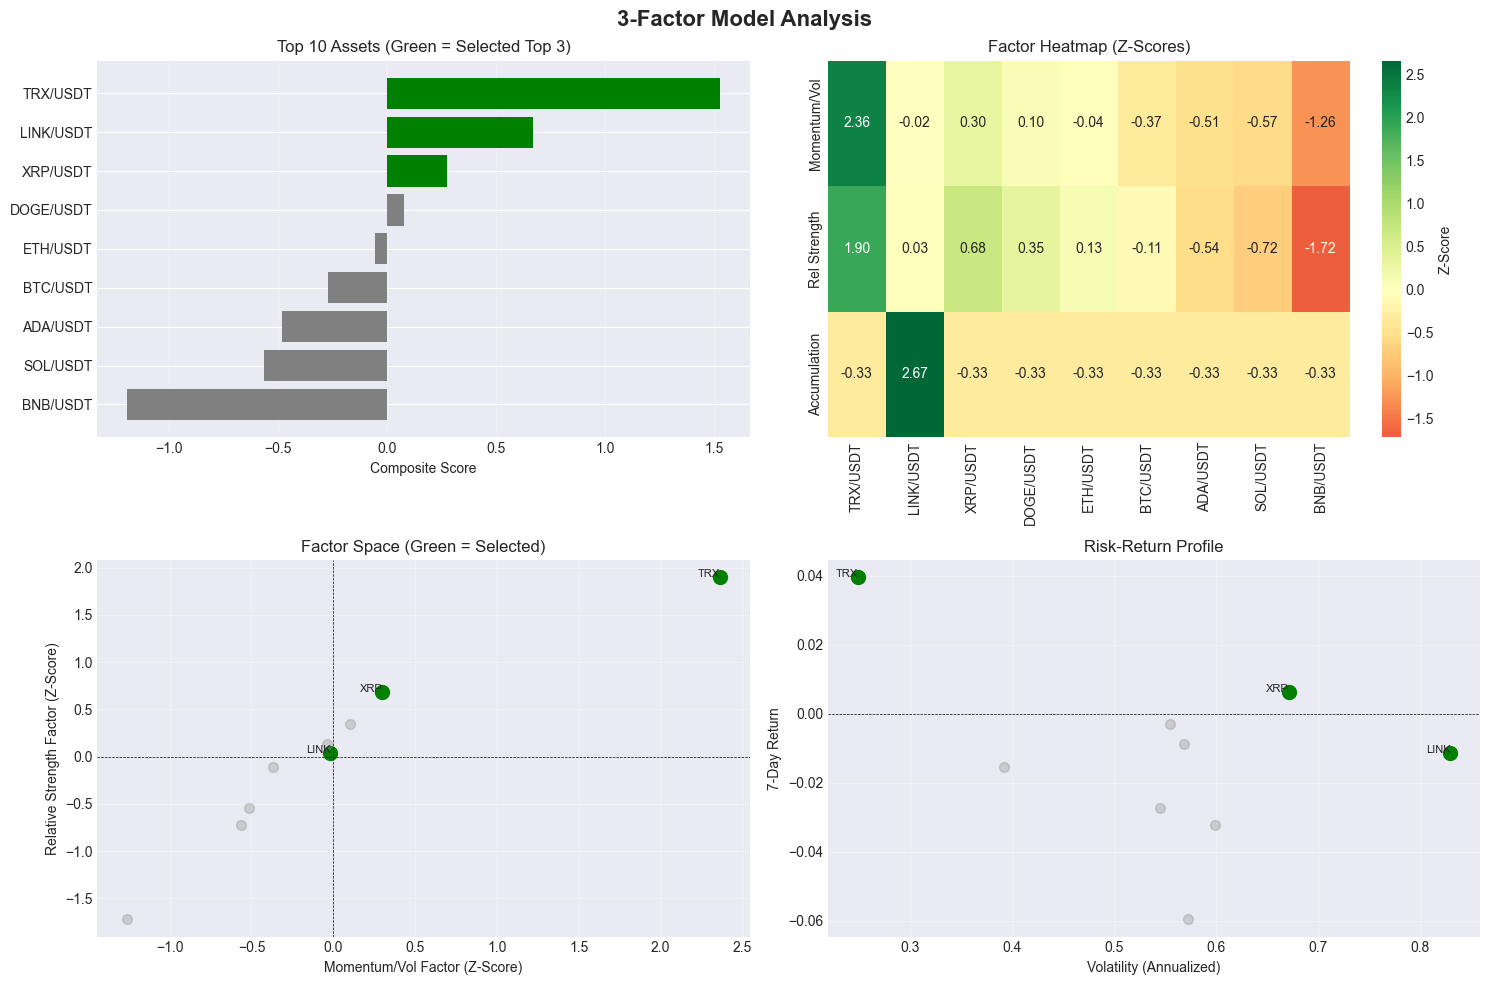


✅ STRATEGY EXECUTION COMPLETE

Next steps:
1. Review the selected assets and position weights above
2. Check factor scores to understand WHY each asset was selected
3. Rebalance weekly (re-run this cell every Sunday)
4. Monitor performance and adjust factor weights if needed

⚠️  DISCLAIMER: This is for educational purposes only, not financial advice!


In [155]:
# Generate signals for top 3 assets
scores_df, position_weights, selected_symbols = generate_trading_signals(crypto_data, top_n=3)
    
# Visualize results
plot_factor_comparison(scores_df, top_n=3)

print("\n" + "="*80)
print("✅ STRATEGY EXECUTION COMPLETE")
print("="*80)
print("\nNext steps:")
print("1. Review the selected assets and position weights above")
print("2. Check factor scores to understand WHY each asset was selected")
print("3. Rebalance weekly (re-run this cell every Sunday)")
print("4. Monitor performance and adjust factor weights if needed")
print("\n⚠️  DISCLAIMER: This is for educational purposes only, not financial advice!")

## Backtesting
Code with simulated transaction costs- need more rigour when we find a strategy that could have more alpha.

In [156]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta

In [157]:
def fetch_long_history(exchange, symbol, start_date, timeframe='1h'):
    """Fetch long historical OHLCV data in chunks from a specific start date."""
    since = exchange.parse8601(start_date + 'T00:00:00Z')
    all_ohlcv = []
    
    print(f"Fetching historical data for {symbol} since {start_date}...")
    while True:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
            if not ohlcv:
                break
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + 1
            time.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            print(f"Error fetching chunk for {symbol}: {e}")
            break
            
    if not all_ohlcv:
        return None
        
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

In [158]:
def rank_and_score_all_assets_quiet(crypto_data):
    all_scores = {}
    for symbol in crypto_data.keys():
        try:
            if 'BTC/USDT' not in crypto_data or crypto_data['BTC/USDT'].dropna().empty:
                continue
            if crypto_data[symbol].shape[0] < 200:
                continue
            factors = calculate_composite_score(crypto_data, symbol)
            all_scores[symbol] = factors
        except Exception:
            pass

    if not all_scores:
        return pd.DataFrame()
        
    scores_df = pd.DataFrame(all_scores).T.dropna()
    if scores_df.empty:
        return scores_df

    for col in ['momentum_vol_raw', 'relative_strength_raw', 'accumulation_raw']:
        mean = scores_df[col].mean()
        std = scores_df[col].std()
        if std == 0:
            scores_df[col + '_zscore'] = 0
        else:
            scores_df[col + '_zscore'] = (scores_df[col] - mean) / std
            
    weights = {'momentum_vol': 0.40, 'relative_strength': 0.35, 'accumulation': 0.25}
    scores_df['composite_score'] = (
        scores_df['momentum_vol_raw_zscore'] * weights['momentum_vol'] +
        scores_df['relative_strength_raw_zscore'] * weights['relative_strength'] +
        scores_df['accumulation_raw_zscore'] * weights['accumulation']
    )
    scores_df = scores_df.sort_values('composite_score', ascending=False)
    return scores_df

In [161]:
def calculate_position_weights_quiet(crypto_data, selected_symbols):
    inverse_vols = {}
    for symbol in selected_symbols:
        df = crypto_data[symbol]
        current_vol = df['volatility_24h_annualized'].iloc[-1]
        if pd.isna(current_vol) or current_vol == 0:
            inverse_vols[symbol] = 0
        else:
            inverse_vols[symbol] = 1.0 / current_vol
    
    total_inverse_vol = sum(inverse_vols.values())
    if total_inverse_vol == 0:
        num_symbols = len(selected_symbols)
        return {symbol: 1.0 / num_symbols for symbol in selected_symbols} if num_symbols > 0 else {}
        
    weights = {symbol: inv_vol / total_inverse_vol for symbol, inv_vol in inverse_vols.items()}
    return weights

In [162]:
def generate_trading_signals_quiet(crypto_data, top_n=3):
    scores_df = rank_and_score_all_assets_quiet(crypto_data)
    if scores_df.empty:
        return scores_df, {}, []
        
    selected_symbols = scores_df.head(top_n).index.tolist()
    position_weights = calculate_position_weights_quiet(crypto_data, selected_symbols)
    return scores_df, position_weights, selected_symbols

In [163]:
def calculate_performance_metrics(equity_curve, timeframe='1h'):
    total_return = (equity_curve.iloc[-1] - 1) * 100
    periods_per_year = {'1h': 24 * 365.25, '1d': 365.25}[timeframe]
    num_periods = len(equity_curve)
    years = num_periods / periods_per_year
    annualized_return = ((equity_curve.iloc[-1])**(1/years) - 1) * 100
    returns = equity_curve.pct_change().dropna()
    annualized_volatility = returns.std() * np.sqrt(periods_per_year) * 100
    sharpe_ratio = (annualized_return / 100) / (annualized_volatility / 100) if annualized_volatility != 0 else 0
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    return {
        "Total Return (%)": total_return,
        "Annualized Return (%)": annualized_return,
        "Annualized Volatility (%)": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }

In [164]:
# --- 2. BACKTESTING EXECUTION ---

# Backtest Parameters
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=7 * 30) # Approx 7 months
initial_capital = 10000.0
timeframe = '1h'
backtest_universe = list(crypto_data.keys())
if 'BTC/USDT' not in backtest_universe:
    backtest_universe.append('BTC/USDT')

# Fetch full historical data
all_historical_data = {}
for symbol in backtest_universe:
    df = fetch_long_history(exchange, symbol, start_date.strftime('%Y-%m-%d'), timeframe)
    if df is not None and not df.empty:
        all_historical_data[symbol] = df

valid_symbols = list(all_historical_data.keys())
print(f"\nProceeding with {len(valid_symbols)} symbols that have sufficient historical data.")

# Prepare data for backtest
print("\nCalculating features for all historical data (this may take a moment)...")
prices_dict, returns_dict, backtest_crypto_data = {}, {}, {}
for symbol in valid_symbols:
    df_with_features = add_technical_features(all_historical_data[symbol].copy())
    backtest_crypto_data[symbol] = df_with_features
    prices_dict[symbol] = df_with_features['close']
    returns_dict[symbol] = df_with_features['returns']

prices_df = pd.DataFrame(prices_dict).ffill()
returns_df = pd.DataFrame(returns_dict).fillna(0)
sim_start_date = prices_df.index.min() + timedelta(days=30)
prices_df = prices_df.loc[sim_start_date:]
returns_df = returns_df.loc[sim_start_date:]

# Run simulation
print("\nRunning backtest simulation...")
weights_df = pd.DataFrame(0.0, index=prices_df.index, columns=valid_symbols)
current_weights = pd.Series(0.0, index=valid_symbols)
last_rebalance_date = pd.NaT

for date in prices_df.index:
    if date.weekday() == 0 and date.date() != last_rebalance_date:
        last_rebalance_date = date.date()
        print(f"Rebalancing on {date.strftime('%Y-%m-%d')}...")
        data_slice = {symbol: df.loc[:date] for symbol, df in backtest_crypto_data.items()}
        try:
            _, position_weights, _ = generate_trading_signals_quiet(data_slice, top_n=3)
            current_weights.update(pd.Series(0.0, index=valid_symbols))
            if position_weights:
                current_weights.update(pd.Series(position_weights))
        except Exception as e:
            print(f"  Error on rebalance day {date}: {e}. Holding previous weights.")
    weights_df.loc[date] = current_weights

/var/folders/mk/spx5m7bs31zcl288wyr4sdfm0000gn/T/ipykernel_4149/3659488567.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow()


Fetching historical data for BTC/USDT since 2025-03-25...
Fetching historical data for ETH/USDT since 2025-03-25...
Fetching historical data for BNB/USDT since 2025-03-25...
Fetching historical data for XRP/USDT since 2025-03-25...
Fetching historical data for SOL/USDT since 2025-03-25...
Fetching historical data for TRX/USDT since 2025-03-25...
Fetching historical data for DOGE/USDT since 2025-03-25...
Fetching historical data for ADA/USDT since 2025-03-25...
Fetching historical data for LINK/USDT since 2025-03-25...

Proceeding with 9 symbols that have sufficient historical data.

Calculating features for all historical data (this may take a moment)...

Running backtest simulation...
Rebalancing on 2025-04-28...
Rebalancing on 2025-05-05...
Rebalancing on 2025-05-12...
Rebalancing on 2025-05-19...
Rebalancing on 2025-05-26...
Rebalancing on 2025-06-02...
Rebalancing on 2025-06-09...
Rebalancing on 2025-06-16...
Rebalancing on 2025-06-23...
Rebalancing on 2025-06-30...
Rebalancing on 

In [165]:
# --- 3. PERFORMANCE ANALYSIS WITH TRANSACTION COSTS ---

# Define cost assumptions (as a percentage of the traded amount)
trading_fee = 0.001  # 0.1% for typical exchange fee
slippage = 0.0005    # 0.05% for slippage on liquid assets
total_cost_per_trade = trading_fee + slippage

# Calculate turnover: the sum of absolute changes in weights on each rebalance day
# This represents the fraction of the portfolio that was traded (sold and bought)
turnover = weights_df.diff().abs().sum(axis=1)
transaction_costs = turnover * total_cost_per_trade

# Calculate Gross and Net Returns
strategy_returns_gross = (weights_df.shift(1) * returns_df).sum(axis=1)
strategy_returns_net = strategy_returns_gross - transaction_costs

# Calculate Equity Curves
strategy_equity_net = (1 + strategy_returns_net).cumprod()
benchmark_equity = (1 + returns_df['BTC/USDT']).cumprod()


BACKTEST PERFORMANCE METRICS (After Costs)
                         Total Return (%)  Annualized Return (%)  Annualized Volatility (%)  Sharpe Ratio  Max Drawdown (%)  Calmar Ratio
3-Factor Strategy (Net)             15.47                  33.77                      47.50          0.71            -24.09          1.40
BTC Buy & Hold                      15.81                  34.56                      33.56          1.03            -17.05          2.03

Plotting equity curves (including costs)...


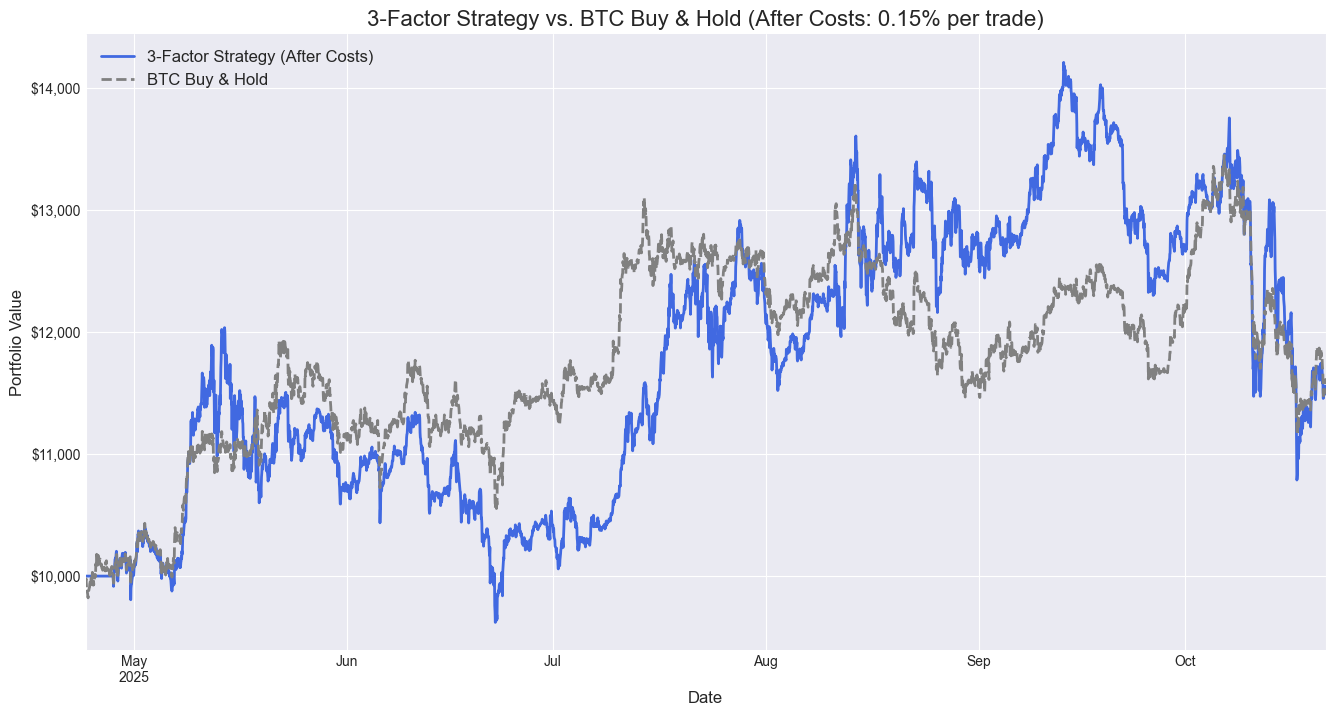

In [166]:
# --- 4. REPORTING AND PLOTTING ---

print("\n" + "="*80)
print("BACKTEST PERFORMANCE METRICS (After Costs)")
print("="*80)
strategy_metrics_net = calculate_performance_metrics(strategy_equity_net)
benchmark_metrics = calculate_performance_metrics(benchmark_equity)

metrics_df_net = pd.DataFrame([strategy_metrics_net, benchmark_metrics], index=['3-Factor Strategy (Net)', 'BTC Buy & Hold'])
print(metrics_df_net.round(2).to_string())

# Plotting
print("\nPlotting equity curves (including costs)...")
fig, ax = plt.subplots(figsize=(16, 8))

(strategy_equity_net * initial_capital).plot(ax=ax, label='3-Factor Strategy (After Costs)', color='royalblue', lw=2)
(benchmark_equity * initial_capital).plot(ax=ax, label='BTC Buy & Hold', color='gray', linestyle='--', lw=2)

ax.set_title(f"3-Factor Strategy vs. BTC Buy & Hold (After Costs: {total_cost_per_trade*100:.2f}% per trade)", fontsize=16)
ax.set_ylabel('Portfolio Value', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(fontsize=12)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
plt.grid(True)
plt.show()

## Bactesting to avoid survivorship bias
We will use CoinGecko to figure out the top 100 crypto tokens, and the top 3 assets at each week to avoid survivorship bias.

In [167]:
# ===========================================================================
# BACKTESTING v3.3: FINAL ROBUST FRAMEWORK WITH DUPLICATE HANDLING
# ===========================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta
import requests

# --- HELPER FUNCTIONS ---

def get_coingecko_ids(n=100):
    """Gets the top N coin IDs and symbols from CoinGecko."""
    print(f"Fetching top {n} coins from CoinGecko to build potential universe...")
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {'vs_currency': 'usd', 'order': 'market_cap_desc', 'per_page': n, 'page': 1}
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        coins = response.json()
        return [{'id': c['id'], 'symbol': c['symbol'].upper()} for c in coins
                if c['symbol'].upper() not in STABLECOINS and c['symbol'].upper() not in WRAPPED_TOKENS]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching from CoinGecko: {e}"); return []

def get_historical_market_caps(coin_ids, days):
    """Fetches historical market caps and handles duplicate dates from the API."""
    print(f"Fetching {days}-day historical market caps for {len(coin_ids)} coins...")
    market_caps_dict = {}
    for i, coin in enumerate(coin_ids):
        coin_id, symbol = coin['id'], coin['symbol']
        print(f"  ({i+1}/{len(coin_ids)}) Fetching for {symbol}...", end="")
        
        url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
        params = {'vs_currency': 'usd', 'days': days, 'interval': 'daily'}
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json().get('market_caps', [])
            if data:
                # Create a raw series which might have duplicate dates
                raw_series = pd.Series(
                    [item[1] for item in data], 
                    index=pd.to_datetime([item[0] for item in data], unit='ms').date
                )
                
                # *** THE FIX IS HERE ***
                # Remove duplicate index entries, keeping only the last occurrence for each date.
                mc_series = raw_series[~raw_series.index.duplicated(keep='last')]
                
                market_caps_dict[symbol] = mc_series
                print(" Done.")
            else:
                print(" No data found.")
            time.sleep(15) # Respect rate limit
        except requests.exceptions.RequestException as e:
            print(f" Failed ({e}).")
            
    market_caps_df = pd.DataFrame(market_caps_dict)
    market_caps_df.index = pd.to_datetime(market_caps_df.index)
    return market_caps_df

def get_top_n_by_mcap_on_date(date, market_caps_df, n=10):
    try:
        caps_on_date = market_caps_df.loc[market_caps_df.index.asof(date)].dropna().sort_values(ascending=False)
        return caps_on_date.head(n).index.tolist()
    except (KeyError, IndexError):
        return []

def run_backtest_simulation(prices_df, backtest_crypto_data, market_caps_df, valid_symbols, rebalance_freq='W-MON', rebalance_top_n=10, strategy_top_n=3):
    print("\nRunning backtest simulation with dynamic universe...")
    weights_df = pd.DataFrame(0.0, index=prices_df.index, columns=valid_symbols)
    current_weights = pd.Series(0.0, index=valid_symbols)
    rebalance_dates = pd.date_range(start=prices_df.index.min(), end=prices_df.index.max(), freq=rebalance_freq)
    
    for date in prices_df.index:
        if date in rebalance_dates:
            active_universe = get_top_n_by_mcap_on_date(date, market_caps_df, n=rebalance_top_n)
            if not active_universe:
                print(f"No market cap data for {date.strftime('%Y-%m-%d')}. Holding previous weights.")
            else:
                print(f"Rebalancing on {date.strftime('%Y-%m-%d')} with universe: {', '.join(active_universe)}")
                data_slice = {f"{s}/USDT": backtest_crypto_data[s].loc[:date] for s in active_universe if s in backtest_crypto_data}
                try:
                    _, position_weights, _ = generate_trading_signals_quiet(data_slice, top_n=strategy_top_n)
                    current_weights = pd.Series(0.0, index=valid_symbols)
                    if position_weights:
                        cleaned_weights = {s.split('/')[0]: w for s, w in position_weights.items()}
                        current_weights.update(pd.Series(cleaned_weights))
                except Exception as e:
                    print(f"  Error on rebalance day {date}: {e}. Holding previous weights.")
        weights_df.loc[date] = current_weights
    return weights_df

def analyze_and_plot_results(weights_df, returns_df, initial_capital, trading_fee, slippage, benchmark_symbol):
    total_cost_per_trade = trading_fee + slippage
    turnover = weights_df.diff().abs().sum(axis=1)
    transaction_costs = turnover * total_cost_per_trade
    strategy_returns_net = (weights_df.shift(1) * returns_df).sum(axis=1) - transaction_costs
    strategy_equity_net = (1 + strategy_returns_net).cumprod()
    benchmark_equity = (1 + returns_df[benchmark_symbol]).cumprod()

    print("\n" + "="*80)
    print("BACKTEST PERFORMANCE METRICS (Dynamic Universe, After Costs)")
    print("="*80)
    strategy_metrics = calculate_performance_metrics(strategy_equity_net)
    benchmark_metrics = calculate_performance_metrics(benchmark_equity)
    metrics_df = pd.DataFrame([strategy_metrics, benchmark_metrics], index=['3-Factor Strategy (Net)', f'{benchmark_symbol} Buy & Hold'])
    print(metrics_df.round(2).to_string())

    print("\nPlotting equity curves...")
    fig, ax = plt.subplots(figsize=(16, 8))
    (strategy_equity_net * initial_capital).plot(ax=ax, label='3-Factor Strategy (Net, Dynamic Universe)', color='royalblue', lw=2)
    (benchmark_equity * initial_capital).plot(ax=ax, label=f'{benchmark_symbol} Buy & Hold', color='gray', linestyle='--', lw=2)
    ax.set_title(f"Dynamic Universe Backtest vs. {benchmark_symbol}", fontsize=16)
    ax.set_ylabel('Portfolio Value'); ax.set_xlabel('Date')
    ax.legend(fontsize=12); ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}')); plt.grid(True); plt.show()


In [168]:
# ===========================================================================
# BACKTESTING FRAMEWORK v4.0: MODULAR FUNCTIONS
# ===========================================================================


# --- HELPER FUNCTIONS ---
# (These are the same functions from your original notebook)
# get_coingecko_ids, fetch_long_history, get_historical_market_caps, etc.
# rank_and_score_all_assets_quiet, calculate_position_weights_quiet, etc.
# calculate_performance_metrics

def prepare_backtest_data(exchange, start_date_str, end_date, potential_universe_size=100, benchmark_symbol='BTC'):
    """
    Handles all slow data gathering and feature engineering. Run this once per session.
    Returns all necessary DataFrames for the simulation.
    """
    print("Step 1: Determining a tradable universe...")
    potential_cg_universe = get_coingecko_ids(potential_universe_size)
    cg_symbols = {c['symbol'] for c in potential_cg_universe}
    
    print(f"Loading markets from {exchange.id} to find tradable USDT pairs...")
    markets = exchange.load_markets()
    tradable_symbols = {s.split('/')[0] for s in markets if s.endswith('/USDT')}
    
    final_universe_symbols = tradable_symbols.intersection(cg_symbols)
    if not final_universe_symbols:
        raise ValueError("No intersection found between CoinGecko top coins and exchange's tradable pairs.")
    print(f"Found {len(final_universe_symbols)} tradable top coins to build the backtest universe.")
    
    final_cg_universe = [c for c in potential_cg_universe if c['symbol'] in final_universe_symbols]
    
    days_history = (end_date - datetime.strptime(start_date_str, '%Y-%m-%d')).days
    market_caps_df = get_historical_market_caps(final_cg_universe, days=days_history)
    
    all_historical_data = {}
    for symbol_upper in final_universe_symbols:
        df = fetch_long_history(exchange, f"{symbol_upper}/USDT", start_date_str, '1h')
        if df is not None and not df.empty:
            all_historical_data[symbol_upper] = df
    
    valid_symbols = list(set(all_historical_data.keys()) & set(market_caps_df.columns))
    if benchmark_symbol not in valid_symbols and benchmark_symbol in all_historical_data:
        valid_symbols.append(benchmark_symbol)
    
    print(f"\nProceeding with {len(valid_symbols)} symbols with complete historical data.")
    
    print("\nStep 2: Calculating features for all historical data...")
    backtest_crypto_data = {symbol: add_technical_features(df.copy()) for symbol, df in all_historical_data.items()}
    
    prices_dict = {symbol: df['close'] for symbol, df in backtest_crypto_data.items() if symbol in valid_symbols}
    returns_dict = {symbol: df['returns'] for symbol, df in backtest_crypto_data.items() if symbol in valid_symbols}

    prices_df = pd.DataFrame(prices_dict).ffill()
    returns_df = pd.DataFrame(returns_dict).fillna(0)
    sim_start_date = prices_df.index.min() + timedelta(days=30)
    prices_df = prices_df.loc[sim_start_date:]
    returns_df = returns_df.loc[sim_start_date:]

    print("\nData preparation complete.")
    return prices_df, returns_df, backtest_crypto_data, market_caps_df, valid_symbols

In [169]:
# ===========================================================================
# STEP 1: PREPARE ALL DATA FOR BACKTESTING (RUN ONCE PER SESSION)
# ===========================================================================

# Define the time period for the backtest
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=7 * 30)

# Execute the data preparation
(
    prices_df, 
    returns_df, 
    backtest_crypto_data, 
    market_caps_df, 
    valid_symbols
) = prepare_backtest_data(
    exchange=exchange,
    start_date_str=start_date.strftime('%Y-%m-%d'),
    end_date=end_date,
    potential_universe_size=20,
    benchmark_symbol='BTC'
)

/var/folders/mk/spx5m7bs31zcl288wyr4sdfm0000gn/T/ipykernel_4149/4091497868.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow()


Step 1: Determining a tradable universe...
Fetching top 20 coins from CoinGecko to build potential universe...
Loading markets from binance to find tradable USDT pairs...
Found 10 tradable top coins to build the backtest universe.
Fetching 210-day historical market caps for 10 coins...
  (1/10) Fetching for BTC... Done.
  (2/10) Fetching for ETH... Done.
  (3/10) Fetching for BNB... Done.
  (4/10) Fetching for XRP... Done.
  (5/10) Fetching for SOL... Done.
  (6/10) Fetching for TRX... Done.
  (7/10) Fetching for DOGE... Done.
  (8/10) Fetching for ADA... Done.
  (9/10) Fetching for LINK... Done.
  (10/10) Fetching for XLM... Done.
Fetching historical data for TRX/USDT since 2025-03-25...
Fetching historical data for XRP/USDT since 2025-03-25...
Fetching historical data for ETH/USDT since 2025-03-25...
Fetching historical data for SOL/USDT since 2025-03-25...
Fetching historical data for ADA/USDT since 2025-03-25...
Fetching historical data for LINK/USDT since 2025-03-25...
Fetching hi


Running backtest simulation with dynamic universe...
Rebalancing on 2025-04-28 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-05 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-12 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-19 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-26 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-06-02 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, TRX, ADA, LINK, XLM
Rebalancing on 2025-06-09 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, TRX, ADA, LINK, XLM
Rebalancing on 2025-06-16 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, TRX, ADA, LINK, XLM
Rebalancing on 2025-06-23 with universe: BTC, ETH, XRP, BNB, SOL, TRX, DOGE, ADA, LINK, XLM
Rebalancing on 2025-06-30 with universe: BTC, ETH, XRP, BNB, SOL, TRX, DOGE, ADA, LINK, XLM
Rebalancing on 2025-07-07 

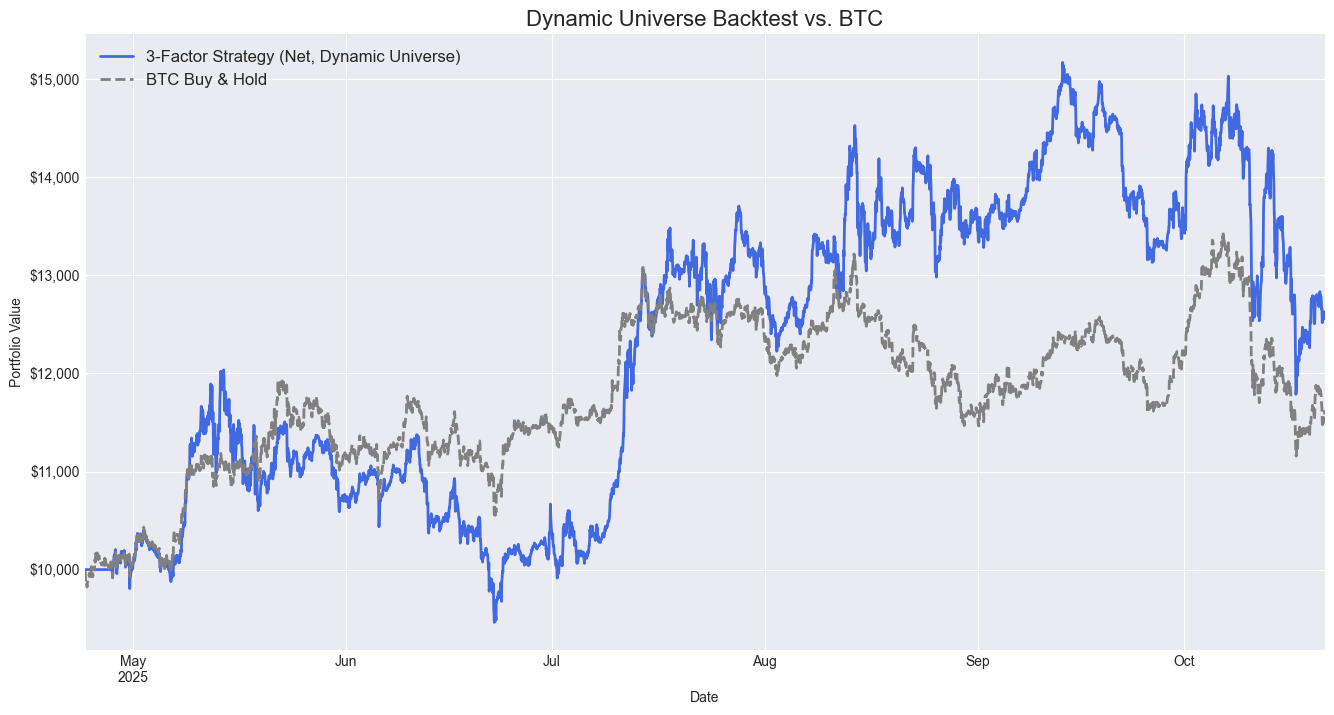

In [170]:
# ===========================================================================
# STEP 2: RUN SIMULATION AND ANALYZE RESULTS (RUN AND MODIFY FREELY)
# ===========================================================================

# --- FIX for the TypeError: Explicitly pass only relevant args to simulation ---
weights_df = run_backtest_simulation(
    prices_df=prices_df, 
    backtest_crypto_data=backtest_crypto_data, 
    market_caps_df=market_caps_df, 
    valid_symbols=valid_symbols, 
    rebalance_freq='W-MON', 
    rebalance_top_n=10,  # The size of the dynamic universe to choose from
    strategy_top_n=3     # The number of assets to go long
)

# Analyze performance and plot the results
final_metrics = analyze_and_plot_results(
    weights_df=weights_df, 
    returns_df=returns_df, 
    initial_capital=10000.0, 
    trading_fee=0.001, 
    slippage=0.0005, 
    benchmark_symbol='BTC'
)

Ok, so our 3 factor startegy performs terribly when we remove the lookahead bias. More work to be done! 

## More EDA
Given the terrible performance of our 3 factor strategy, it will be fruitful to look at our data through EDA lens and see if we can actually get anything going!

Generating Strategy Development Dashboard...


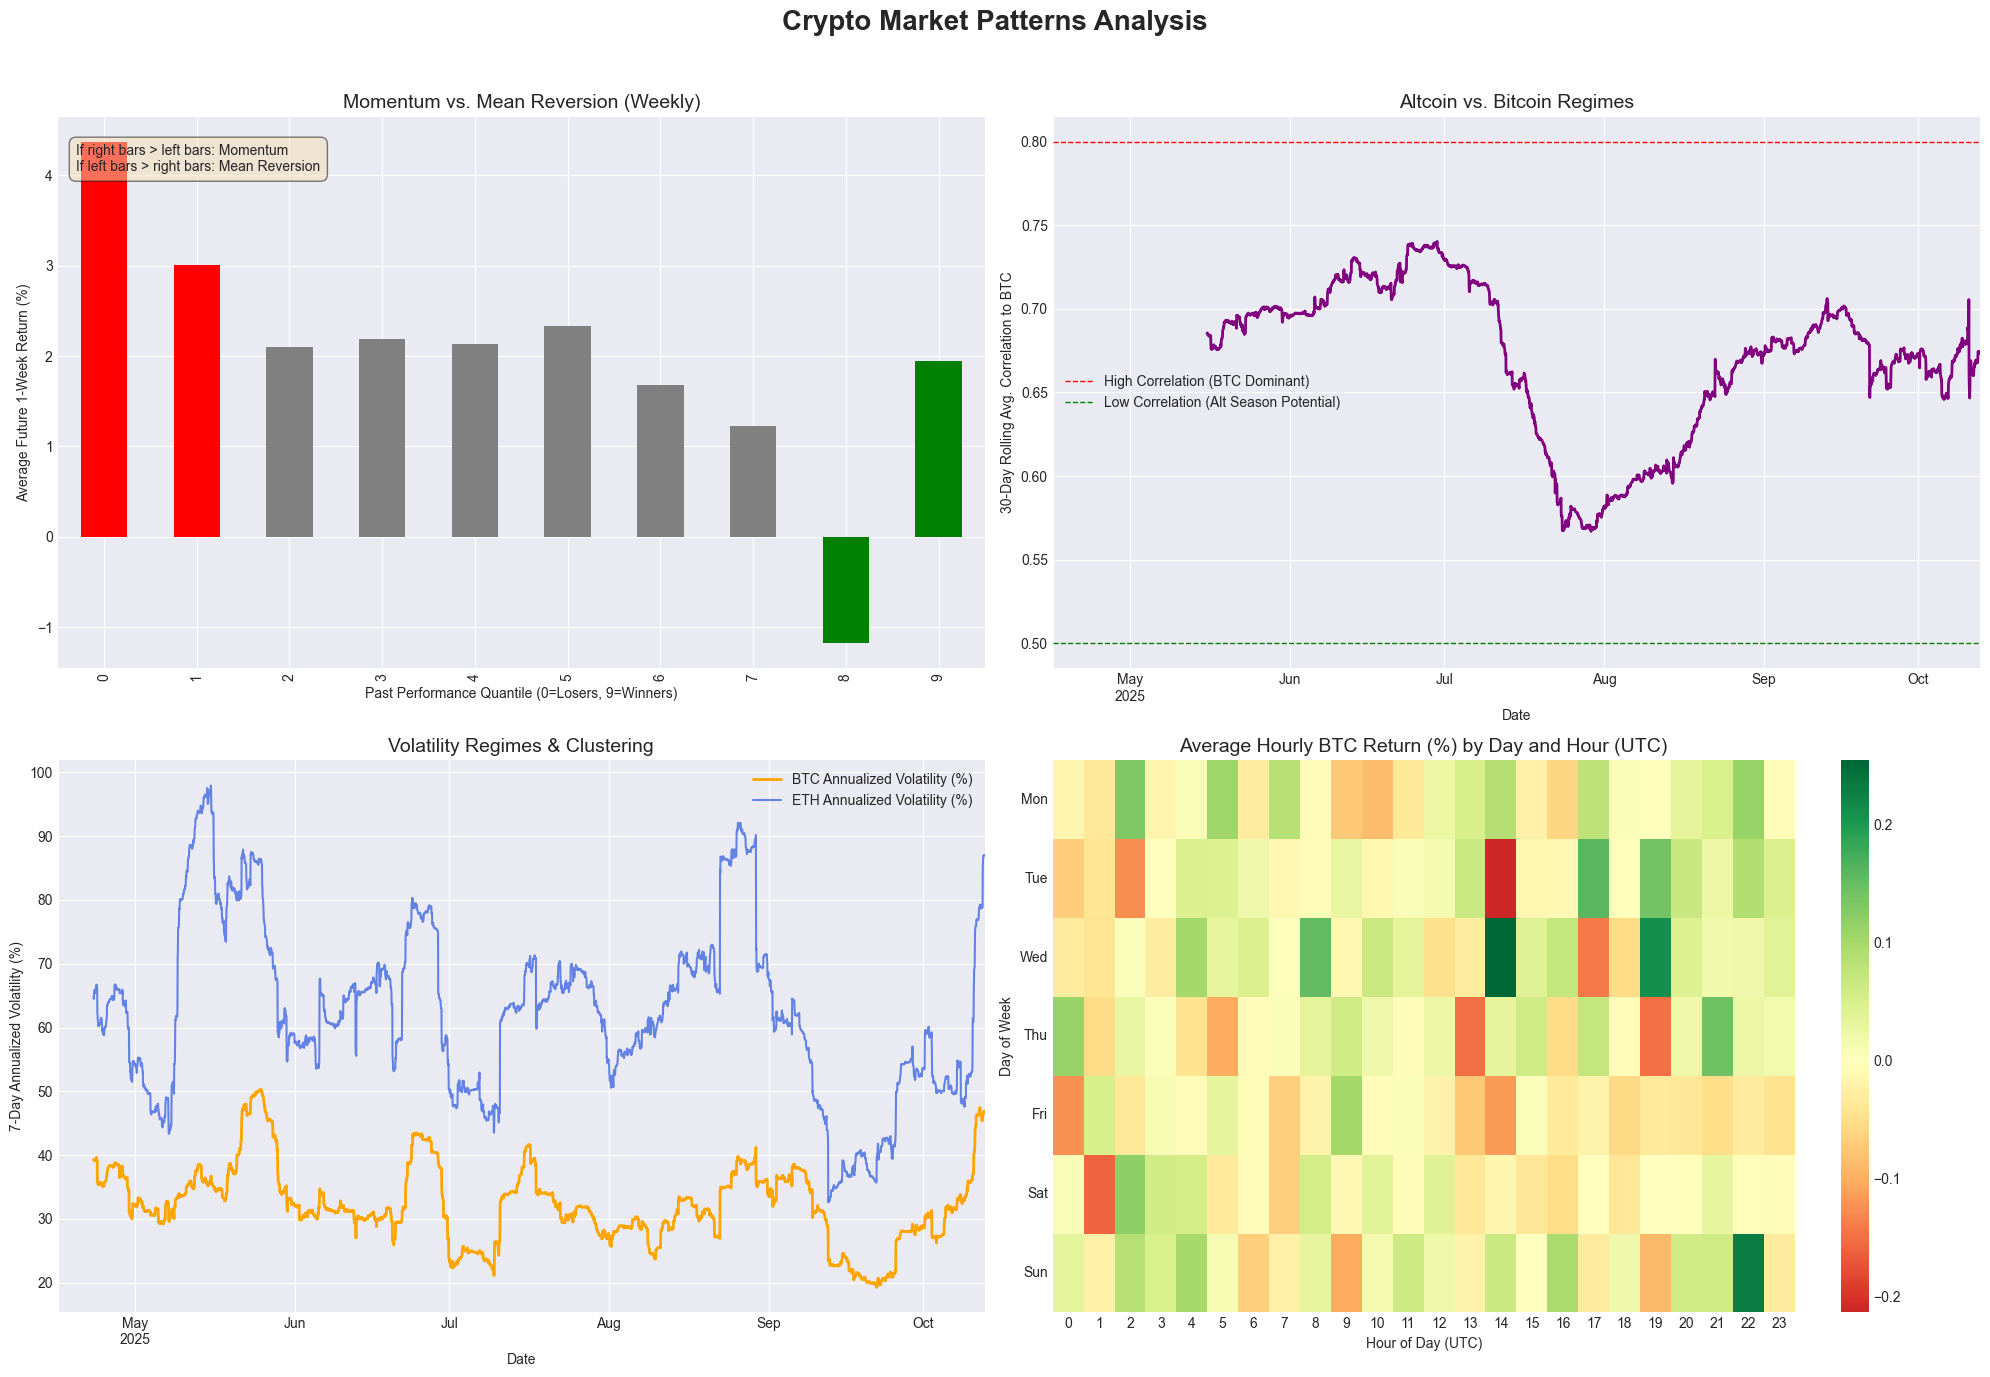

In [97]:
# ===========================================================================
# STRATEGY DEVELOPMENT DASHBOARD: VISUALIZING MARKET PATTERNS
# ===========================================================================
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("Generating Strategy Development Dashboard...")

# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Crypto Market Patterns Analysis', fontsize=20, fontweight='bold')
plt.style.use('seaborn-v0_8-darkgrid')

# --- Plot 1: Momentum vs. Mean Reversion ---
# Question: Do assets that perform well over one week continue to perform well the next week (momentum), or do they revert (mean-reversion)?
ax1 = axes[0, 0]
lookback_period = 7 * 24  # 1 week in hours
forward_period = 7 * 24   # 1 week in hours

# Calculate past returns for all assets
past_returns = returns_df.rolling(window=lookback_period).sum()

# Calculate future returns for all assets
future_returns = returns_df.shift(-forward_period).rolling(window=forward_period).sum()

# Flatten the data and drop NaNs
past = past_returns.stack()
future = future_returns.stack()
performance_df = pd.DataFrame({'past_return': past, 'future_return': future}).dropna()

# Bin assets into performance quantiles (e.g., losers, middles, winners)
try:
    performance_df['quantile'] = pd.qcut(performance_df['past_return'], 10, labels=False, duplicates='drop')
    quantile_analysis = performance_df.groupby('quantile')['future_return'].mean() * 100

    quantile_analysis.plot(kind='bar', ax=ax1, color=['red']*2 + ['gray']*6 + ['green']*2)
    ax1.set_title('Momentum vs. Mean Reversion (Weekly)', fontsize=14)
    ax1.set_xlabel('Past Performance Quantile (0=Losers, 9=Winners)', fontsize=10)
    ax1.set_ylabel('Average Future 1-Week Return (%)', fontsize=10)
    ax1.text(0.02, 0.95, "If right bars > left bars: Momentum\nIf left bars > right bars: Mean Reversion", 
             transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
except Exception as e:
    ax1.text(0.5, 0.5, f"Could not generate plot:\n{e}", ha='center', va='center')


# --- Plot 2: Altcoin vs. Bitcoin Season (Rolling Correlation) ---
# Question: How correlated are altcoins to Bitcoin over time? Are there regimes where they move independently?
ax2 = axes[0, 1]
altcoins = [c for c in returns_df.columns if c != 'BTC']
rolling_corr = returns_df[altcoins].rolling(window=30*24).corr(returns_df['BTC']).mean(axis=1) # 30-day rolling avg correlation

rolling_corr.plot(ax=ax2, color='purple', lw=2)
ax2.set_title('Altcoin vs. Bitcoin Regimes', fontsize=14)
ax2.set_ylabel('30-Day Rolling Avg. Correlation to BTC', fontsize=10)
ax2.set_xlabel('Date', fontsize=10)
ax2.axhline(0.8, color='red', linestyle='--', lw=1, label='High Correlation (BTC Dominant)')
ax2.axhline(0.5, color='green', linestyle='--', lw=1, label='Low Correlation (Alt Season Potential)')
ax2.legend()


# --- Plot 3: Volatility Clustering ---
# Question: Does volatility come in waves? Can low volatility be a predictor of a big move?
ax3 = axes[1, 0]
btc_vol = returns_df['BTC'].rolling(window=24*7).std() * np.sqrt(365*24) * 100 # 7-day annualized vol
eth_vol = returns_df['ETH'].rolling(window=24*7).std() * np.sqrt(365*24) * 100

btc_vol.plot(ax=ax3, label='BTC Annualized Volatility (%)', color='orange', lw=2)
eth_vol.plot(ax=ax3, label='ETH Annualized Volatility (%)', color='royalblue', lw=1.5, alpha=0.8)
ax3.set_title('Volatility Regimes & Clustering', fontsize=14)
ax3.set_ylabel('7-Day Annualized Volatility (%)', fontsize=10)
ax3.set_xlabel('Date', fontsize=10)
ax3.legend()


# --- Plot 4: Time-of-Week & Time-of-Day Heatmap ---
# Question: Are there specific days or times that consistently have better or worse returns?
ax4 = axes[1, 1]
heatmap_data = returns_df.copy()
heatmap_data['day_of_week'] = heatmap_data.index.dayofweek
heatmap_data['hour'] = heatmap_data.index.hour
avg_btc_returns_by_time = heatmap_data.pivot_table(
    values='BTC', 
    index='day_of_week', 
    columns='hour', 
    aggfunc='mean'
) * 100 # In percent

sns.heatmap(avg_btc_returns_by_time, ax=ax4, cmap='RdYlGn', center=0)
ax4.set_title('Average Hourly BTC Return (%) by Day and Hour (UTC)', fontsize=14)
ax4.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
ax4.set_xlabel('Hour of Day (UTC)', fontsize=10)
ax4.set_ylabel('Day of Week', fontsize=10)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

When we reduce the universe to the top 11 crypto assets (by market cap on Mondays), we see that the metrics of total returns and Sharpe ratio for our strategy is much better when we took the top 100. However, it still fails to beat the benchmark.

We also see both mean reversion and momentum factors in the top 11 asset universe. Our next steps are to try a mean reversion strategy (long the bottom 3 assets for each Monday), then to combine them into a momentum and mean reversion strategy.

## Trading Strategy 2: Mean reversion for bottom 3 assets (assets 9-11 by market cap)


Running MEAN-REVERSION backtest simulation...
Rebalancing on 2025-04-21 with universe: BTC, ETH, XRP, BNB, SOL, TRX, DOGE, ADA, LINK, XLM
Rebalancing on 2025-04-28 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-05 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-12 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-19 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-26 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-06-02 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, TRX, ADA, LINK, XLM
Rebalancing on 2025-06-09 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, TRX, ADA, LINK, XLM
Rebalancing on 2025-06-16 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, TRX, ADA, BCH, LINK
Rebalancing on 2025-06-23 with universe: BTC, ETH, XRP, BNB, SOL, TRX, DOGE, ADA, BCH, LINK
Rebalancing on 2025-06-30 with un

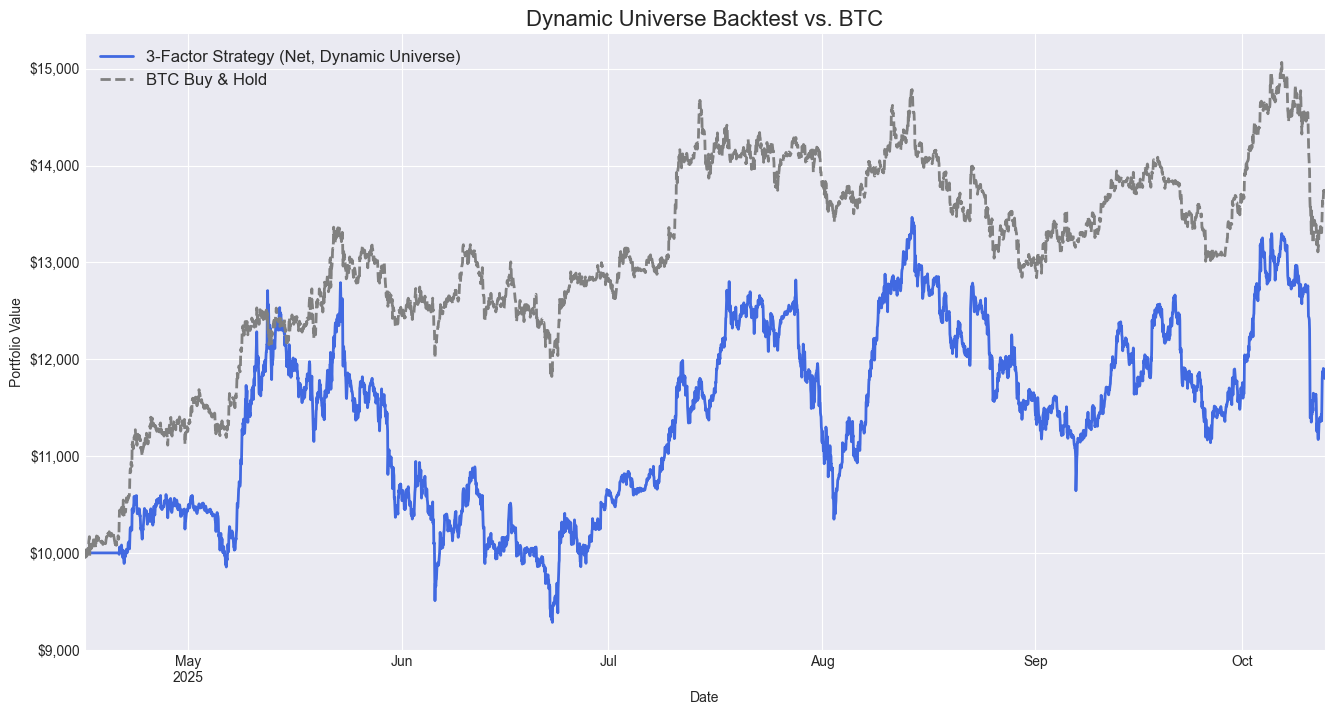

In [98]:
# ===========================================================================
# STEP 2 (MODIFIED): RUN MEAN-REVERSION STRATEGY AND ANALYZE
# ===========================================================================

# --- A NEW "QUIET" FUNCTION FOR MEAN REVERSION ---
def generate_mean_reversion_signals_quiet(crypto_data, top_n=3):
    """
    This is a modified signal generator for the backtest.
    It ranks assets by the factor model and selects the BOTTOM n (the "losers").
    """
    # Rank all assets in the usual way (high score = strong momentum)
    scores_df = rank_and_score_all_assets_quiet(crypto_data)
    if scores_df.empty:
        return scores_df, {}, []
        
    # *** THE KEY CHANGE IS HERE ***
    # Instead of head(top_n), we take tail(top_n) to get the worst-ranked assets.
    selected_symbols = scores_df.tail(top_n).index.tolist()
    
    # We still use risk-parity for position sizing, just on a different set of assets.
    position_weights = calculate_position_weights_quiet(crypto_data, selected_symbols)
    return scores_df, position_weights, selected_symbols

def run_backtest_simulation_mean_reversion(prices_df, backtest_crypto_data, market_caps_df, valid_symbols, rebalance_freq='W-MON', rebalance_top_n=10, strategy_bottom_n=3):
    """
    Modified simulation loop that calls the mean-reversion signal generator.
    """
    print("\nRunning MEAN-REVERSION backtest simulation...")
    weights_df = pd.DataFrame(0.0, index=prices_df.index, columns=valid_symbols)
    current_weights = pd.Series(0.0, index=valid_symbols)
    rebalance_dates = pd.date_range(start=prices_df.index.min(), end=prices_df.index.max(), freq=rebalance_freq)
    
    for date in prices_df.index:
        if date in rebalance_dates:
            active_universe = get_top_n_by_mcap_on_date(date, market_caps_df, n=rebalance_top_n)
            if not active_universe:
                print(f"No market cap data for {date.strftime('%Y-%m-%d')}. Holding previous weights.")
            else:
                print(f"Rebalancing on {date.strftime('%Y-%m-%d')} with universe: {', '.join(active_universe)}")
                data_slice = {f"{s}/USDT": backtest_crypto_data[s].loc[:date] for s in active_universe if s in backtest_crypto_data}
                try:
                    # Call the new mean-reversion function
                    _, position_weights, _ = generate_mean_reversion_signals_quiet(data_slice, top_n=strategy_bottom_n)
                    
                    current_weights = pd.Series(0.0, index=valid_symbols)
                    if position_weights:
                        cleaned_weights = {s.split('/')[0]: w for s, w in position_weights.items()}
                        current_weights.update(pd.Series(cleaned_weights))
                except Exception as e:
                    print(f"  Error on rebalance day {date}: {e}. Holding previous weights.")
        weights_df.loc[date] = current_weights
    return weights_df


# --- EXECUTE THE MEAN-REVERSION BACKTEST ---

# Run the new simulation logic
weights_df_mr = run_backtest_simulation_mean_reversion(
    prices_df=prices_df, 
    backtest_crypto_data=backtest_crypto_data, 
    market_caps_df=market_caps_df, 
    valid_symbols=valid_symbols, 
    rebalance_freq='W-MON', 
    rebalance_top_n=10,
    strategy_bottom_n=3  # Long the bottom 3
)

# Analyze and plot the results (the analysis function is reusable)
final_metrics_mr = analyze_and_plot_results(
    weights_df=weights_df_mr, 
    returns_df=returns_df, 
    initial_capital=10000.0, 
    trading_fee=0.001, 
    slippage=0.0005, 
    benchmark_symbol='BTC'
)

## Trading Strategy 3: Quality Dip Buying Strategy
Given that our 3 factor mean reversion strategy drastically underperforms our momentum strategy, we are making some adjustments to do a quality dip buying strategy:
- identify the universe. In our case, it's the top 10 assets
- filter for the dip- get the 5 worst performmers 
- filter for the 'quality dips'- among the 5 worst performers, we run our 3 factor model and get the top 3
- we then execute (long) these 3 assets


Running 'Quality Dip Buying' backtest simulation...
Rebalancing on 2025-04-21 with universe: BTC, ETH, XRP, BNB, SOL, TRX, DOGE, ADA, LINK, XLM
Rebalancing on 2025-04-28 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-05 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-12 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
  -> Selected Quality Dips: BNB, XLM, BTC
Rebalancing on 2025-05-19 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-05-26 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, ADA, TRX, LINK, XLM
Rebalancing on 2025-06-02 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, TRX, ADA, LINK, XLM
Rebalancing on 2025-06-09 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, TRX, ADA, LINK, XLM
Rebalancing on 2025-06-16 with universe: BTC, ETH, XRP, BNB, SOL, DOGE, TRX, ADA, BCH, LINK
Rebalancing on 2025-06-23 with universe: BTC, ETH, XRP, BNB, SOL, TRX, DOGE, 

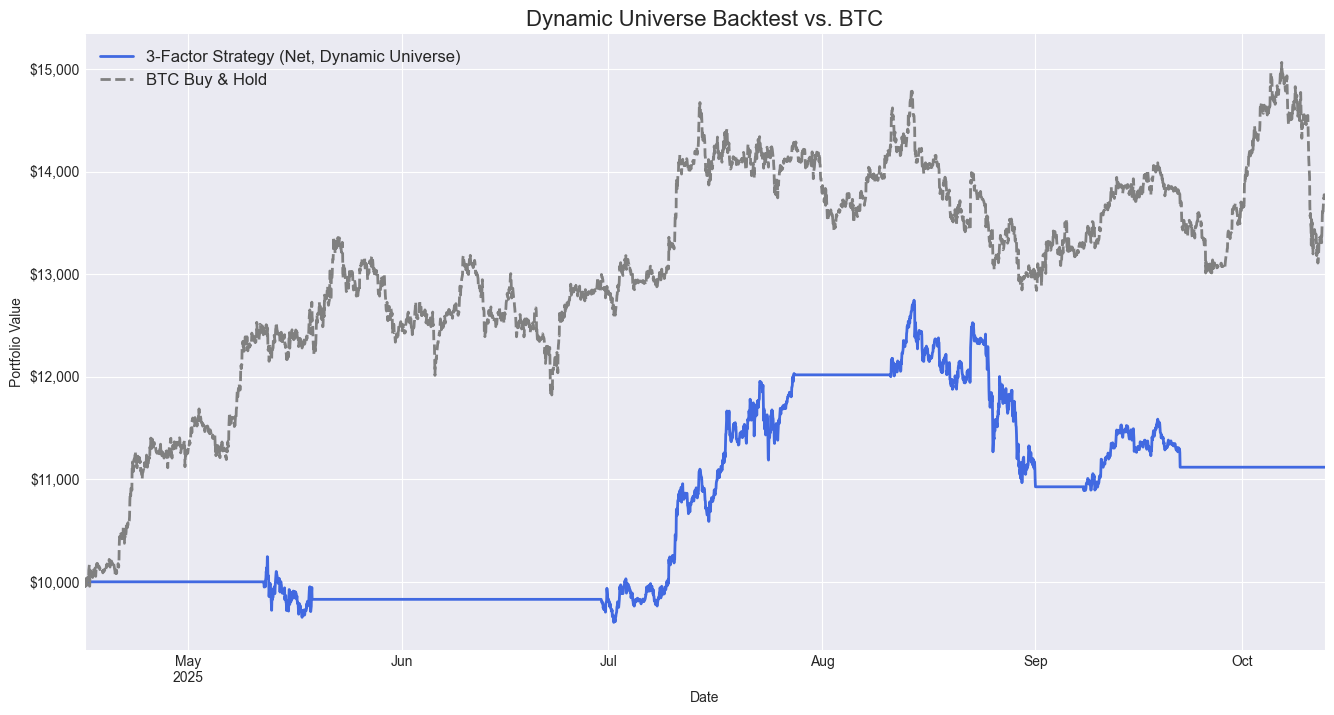

In [99]:
# ===========================================================================
# STEP 2 (NEW STRATEGY): RUN "QUALITY DIP BUYING" BACKTEST
# ===========================================================================

# --- A NEW "QUIET" FUNCTION FOR THE "QUALITY DIP BUYING" STRATEGY ---
def generate_quality_dip_signals_quiet(crypto_data, strategy_top_n=3, dip_quantile=0.5):
    """
    Identifies assets in a short-term dip but with high factor scores ("quality").
    1. Filters for the worst performers over the last week (the "dip").
    2. Ranks these dippers by the 3-factor model (the "quality").
    3. Selects the top N from this ranked list of dippers.
    """
    if not crypto_data:
        return pd.DataFrame(), {}, []

    # Step 1: Identify the "dip" candidates
    # Calculate 7-day return for all assets in the current universe
    weekly_returns = {}
    for symbol, df in crypto_data.items():
        if 'momentum_7d' in df.columns and not df['momentum_7d'].empty:
            weekly_returns[symbol] = df['momentum_7d'].iloc[-1]
    
    if not weekly_returns:
        return pd.DataFrame(), {}, []

    # Sort by performance to find the worst performers
    returns_series = pd.Series(weekly_returns).sort_values(ascending=True)
    
    # Define the "dipper universe" as the bottom half (or specified quantile)
    num_dippers = int(len(returns_series) * dip_quantile)
    dipper_universe_symbols = returns_series.head(num_dippers).index.tolist()
    
    # Step 2: Filter for "quality" within the dipper universe
    # Create a new data dict containing only the dip candidates
    dipper_data = {symbol: df for symbol, df in crypto_data.items() if symbol in dipper_universe_symbols}
    
    if not dipper_data:
        return pd.DataFrame(), {}, []
        
    # Rank these dip candidates using our original 3-factor model
    quality_ranked_dippers = rank_and_score_all_assets_quiet(dipper_data)
    
    if quality_ranked_dippers.empty:
        return pd.DataFrame(), {}, []

    # Step 3: Select the top N "quality dippers"
    selected_symbols = quality_ranked_dippers.head(strategy_top_n).index.tolist()
    
    # Step 4: Calculate weights for the final selection
    position_weights = calculate_position_weights_quiet(crypto_data, selected_symbols)
    
    return quality_ranked_dippers, position_weights, selected_symbols


def run_backtest_simulation_quality_dip(prices_df, backtest_crypto_data, market_caps_df, valid_symbols, rebalance_freq='W-MON', rebalance_top_n=10, strategy_top_n=3):
    """
    Modified simulation loop that calls the quality-dip signal generator.
    """
    print("\nRunning 'Quality Dip Buying' backtest simulation...")
    weights_df = pd.DataFrame(0.0, index=prices_df.index, columns=valid_symbols)
    current_weights = pd.Series(0.0, index=valid_symbols)
    rebalance_dates = pd.date_range(start=prices_df.index.min(), end=prices_df.index.max(), freq=rebalance_freq)
    
    for date in prices_df.index:
        if date in rebalance_dates:
            active_universe = get_top_n_by_mcap_on_date(date, market_caps_df, n=rebalance_top_n)
            if not active_universe:
                print(f"No market cap data for {date.strftime('%Y-%m-%d')}. Holding previous weights.")
            else:
                print(f"Rebalancing on {date.strftime('%Y-%m-%d')} with universe: {', '.join(active_universe)}")
                data_slice = {f"{s}/USDT": backtest_crypto_data[s].loc[:date] for s in active_universe if s in backtest_crypto_data}
                try:
                    # Call the new quality-dip function
                    _, position_weights, selected = generate_quality_dip_signals_quiet(data_slice, strategy_top_n=strategy_top_n)
                    
                    if selected:
                        print(f"  -> Selected Quality Dips: {', '.join([s.split('/')[0] for s in selected])}")

                    current_weights = pd.Series(0.0, index=valid_symbols)
                    if position_weights:
                        cleaned_weights = {s.split('/')[0]: w for s, w in position_weights.items()}
                        current_weights.update(pd.Series(cleaned_weights))
                except Exception as e:
                    print(f"  Error on rebalance day {date}: {e}. Holding previous weights.")
        
        weights_df.loc[date] = current_weights
    return weights_df


# --- EXECUTE THE "QUALITY DIP BUYING" BACKTEST ---

# Run the new simulation logic
weights_df_qdb = run_backtest_simulation_quality_dip(
    prices_df=prices_df, 
    backtest_crypto_data=backtest_crypto_data, 
    market_caps_df=market_caps_df, 
    valid_symbols=valid_symbols, 
    rebalance_freq='W-MON', 
    rebalance_top_n=10,
    strategy_top_n=3
)

# Analyze and plot the results
# The analysis function is reusable and will be renamed for clarity
final_metrics_qdb = analyze_and_plot_results(
    weights_df=weights_df_qdb, 
    returns_df=returns_df, 
    initial_capital=10000.0, 
    trading_fee=0.001, 
    slippage=0.0005, 
    benchmark_symbol='BTC'
)

Oof! Performance is terrible. When we look at our transaction steps, it's clear that often we are picking large market cap assets like BTC and BNB. What happened in practice was that our 3 factor model often pick these large cap assets (due to their lower volatility as quality asset). However, we tend to sell them when there is some price recovery, and we pick another asset. This becomes a case of buy high sell low.

Next, let's try adding a macro factor- check if the price of BTC is above its 21 week exponential moving average. If it is, then the market is bullish, and we still try to capture that mean reversion. Else, we move to 100% cash. This prevents us from buying as the market is crashing.

## Trading Strategy 4: Quality Buying Dip only in bull market

Preparing BTC regime filter (21-week EMA)...
BTC regime filter prepared.

Running 'Quality Dip Buying' backtest with BTC Regime Filter...
Rebalancing on 2025-04-21 (Market: Bullish)
  -> No quality dips found. Moving to cash.
Rebalancing on 2025-04-28 (Market: Bullish)
  -> No quality dips found. Moving to cash.
Rebalancing on 2025-05-05 (Market: Bearish - BTC below 21w EMA). Moving to 100% cash.
Rebalancing on 2025-05-12 (Market: Bullish)
  -> Selected Quality Dips: BNB, XLM, BTC
Rebalancing on 2025-05-19 (Market: Bullish)
  -> No quality dips found. Moving to cash.
Rebalancing on 2025-05-26 (Market: Bullish)
  -> No quality dips found. Moving to cash.
Rebalancing on 2025-06-02 (Market: Bearish - BTC below 21w EMA). Moving to 100% cash.
Rebalancing on 2025-06-09 (Market: Bullish)
  -> No quality dips found. Moving to cash.
Rebalancing on 2025-06-16 (Market: Bearish - BTC below 21w EMA). Moving to 100% cash.
Rebalancing on 2025-06-23 (Market: Bearish - BTC below 21w EMA). Moving to 100

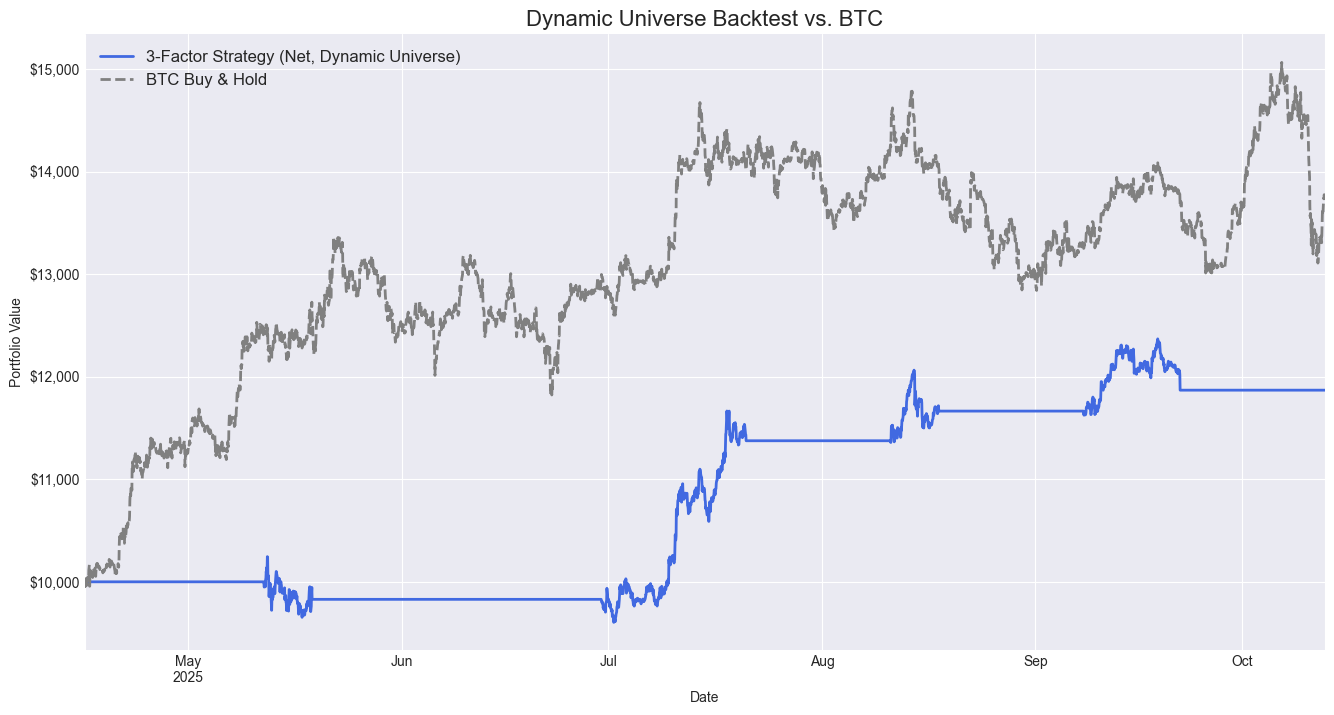

In [100]:
# ===========================================================================
# STEP 2 (NEW STRATEGY): RUN "QUALITY DIP BUYING" BACKTEST WITH REGIME FILTER
# ===========================================================================

# --- A "QUIET" FUNCTION FOR THE "QUALITY DIP BUYING" STRATEGY (Unchanged) ---
def generate_quality_dip_signals_quiet(crypto_data, strategy_top_n=3, dip_quantile=0.5):
    """
    Identifies assets in a short-term dip but with high factor scores ("quality").
    1. Filters for the worst performers over the last week (the "dip").
    2. Ranks these dippers by the 3-factor model (the "quality").
    3. Selects the top N from this ranked list of dippers.
    """
    if not crypto_data:
        return pd.DataFrame(), {}, []

    # Step 1: Identify the "dip" candidates
    weekly_returns = {}
    for symbol, df in crypto_data.items():
        if 'momentum_7d' in df.columns and not df['momentum_7d'].empty:
            weekly_returns[symbol] = df['momentum_7d'].iloc[-1]
    
    if not weekly_returns:
        return pd.DataFrame(), {}, []

    returns_series = pd.Series(weekly_returns).sort_values(ascending=True)
    num_dippers = int(len(returns_series) * dip_quantile)
    dipper_universe_symbols = returns_series.head(num_dippers).index.tolist()
    
    # Step 2: Filter for "quality" within the dipper universe
    dipper_data = {symbol: df for symbol, df in crypto_data.items() if symbol in dipper_universe_symbols}
    
    if not dipper_data:
        return pd.DataFrame(), {}, []
        
    quality_ranked_dippers = rank_and_score_all_assets_quiet(dipper_data)
    
    if quality_ranked_dippers.empty:
        return pd.DataFrame(), {}, []

    # Step 3: Select the top N "quality dippers"
    selected_symbols = quality_ranked_dippers.head(strategy_top_n).index.tolist()
    
    # Step 4: Calculate weights for the final selection
    position_weights = calculate_position_weights_quiet(crypto_data, selected_symbols)
    
    return quality_ranked_dippers, position_weights, selected_symbols


# --- NEW: MODIFIED BACKTEST FUNCTION WITH REGIME FILTER ---
def run_backtest_simulation_quality_dip_with_regime_filter(prices_df, backtest_crypto_data, market_caps_df, valid_symbols, btc_regime_filter_df, rebalance_freq='W-MON', rebalance_top_n=10, strategy_top_n=3):
    """
    Modified simulation loop that calls the quality-dip signal generator
    AND applies a BTC vs. 21-week EMA regime filter.
    """
    print("\nRunning 'Quality Dip Buying' backtest with BTC Regime Filter...")
    weights_df = pd.DataFrame(0.0, index=prices_df.index, columns=valid_symbols)
    current_weights = pd.Series(0.0, index=valid_symbols)
    rebalance_dates = pd.date_range(start=prices_df.index.min(), end=prices_df.index.max(), freq=rebalance_freq)
    
    for date in prices_df.index:
        if date in rebalance_dates:
            # --- BTC REGIME FILTER CHECK ---
            try:
                is_bull_market = btc_regime_filter_df.loc[date, 'is_bullish']
            except KeyError:
                print(f"  Warning: No BTC regime data for {date.strftime('%Y-%m-%d')}. Defaulting to cash for safety.")
                is_bull_market = False # Default to safety if date is missing

            if is_bull_market:
                # --- BULL MARKET: Execute the original strategy ---
                print(f"Rebalancing on {date.strftime('%Y-%m-%d')} (Market: Bullish)")
                active_universe = get_top_n_by_mcap_on_date(date, market_caps_df, n=rebalance_top_n)
                if not active_universe:
                    print(f"  No market cap data for {date.strftime('%Y-%m-%d')}. Holding previous weights.")
                else:
                    data_slice = {f"{s}/USDT": backtest_crypto_data[s].loc[:date] for s in active_universe if s in backtest_crypto_data}
                    try:
                        _, position_weights, selected = generate_quality_dip_signals_quiet(data_slice, strategy_top_n=strategy_top_n)
                        
                        if selected:
                            print(f"  -> Selected Quality Dips: {', '.join([s.split('/')[0] for s in selected])}")
                        else:
                            print("  -> No quality dips found. Moving to cash.")

                        # Reset weights and update with new positions if any
                        current_weights = pd.Series(0.0, index=valid_symbols)
                        if position_weights:
                            cleaned_weights = {s.split('/')[0]: w for s, w in position_weights.items()}
                            current_weights.update(pd.Series(cleaned_weights))
                    except Exception as e:
                        print(f"  Error on rebalance day {date}: {e}. Holding previous weights.")
            else:
                # --- BEAR MARKET: Move to 100% cash ---
                print(f"Rebalancing on {date.strftime('%Y-%m-%d')} (Market: Bearish - BTC below 21w EMA). Moving to 100% cash.")
                current_weights = pd.Series(0.0, index=valid_symbols)
        
        weights_df.loc[date] = current_weights
    return weights_df


# --- NEW: PREPARE THE BTC REGIME FILTER ---
print("Preparing BTC regime filter (21-week EMA)...")
# A 21-week EMA is approximately 21 * 7 = 147 days
EMA_PERIOD = 147 
btc_prices = prices_df['BTC']
btc_ema = btc_prices.ewm(span=EMA_PERIOD, adjust=False).mean()

# Create a DataFrame for easy lookup during the backtest
btc_regime_filter_df = pd.DataFrame({
    'BTC_Price': btc_prices,
    '21_Week_EMA': btc_ema
})
# The signal is True if the price is ABOVE the EMA
btc_regime_filter_df['is_bullish'] = btc_regime_filter_df['BTC_Price'] > btc_regime_filter_df['21_Week_EMA']
print("BTC regime filter prepared.")


# --- EXECUTE THE "QUALITY DIP BUYING" BACKTEST WITH THE REGIME FILTER ---

# Run the new simulation logic
weights_df_qdb_filtered = run_backtest_simulation_quality_dip_with_regime_filter(
    prices_df=prices_df, 
    backtest_crypto_data=backtest_crypto_data, 
    market_caps_df=market_caps_df, 
    valid_symbols=valid_symbols, 
    btc_regime_filter_df=btc_regime_filter_df, # Pass the new filter data
    rebalance_freq='W-MON', 
    rebalance_top_n=10,
    strategy_top_n=3
)

# Analyze and plot the results
final_metrics_qdb_filtered = analyze_and_plot_results(
    weights_df=weights_df_qdb_filtered, 
    returns_df=returns_df, 
    initial_capital=10000.0, 
    trading_fee=0.001, 
    slippage=0.0005, 
    benchmark_symbol='BTC'
)

Better, but this is still pretty bad compared to our initial 3 factor momentum strategy.

Preparing BTC regime filter (21-week EMA)...
BTC regime filter prepared.

Running 'Top 3-Factor' backtest with BTC Regime Filter...
Rebalancing on 2025-04-21 (Market: Bullish)
  -> Selected Top Factor Assets: LINK, XLM, SOL
Rebalancing on 2025-04-28 (Market: Bullish)
  -> Selected Top Factor Assets: ETH, DOGE, BTC
Rebalancing on 2025-05-05 (Market: Bearish - BTC below 21w EMA). Moving to 100% cash.
Rebalancing on 2025-05-12 (Market: Bullish)
  -> Selected Top Factor Assets: ETH, DOGE, ADA
Rebalancing on 2025-05-19 (Market: Bullish)
  -> Selected Top Factor Assets: BTC, XRP, BNB
Rebalancing on 2025-05-26 (Market: Bullish)
  -> Selected Top Factor Assets: SOL, BNB, TRX
Rebalancing on 2025-06-02 (Market: Bearish - BTC below 21w EMA). Moving to 100% cash.
Rebalancing on 2025-06-09 (Market: Bullish)
  -> Selected Top Factor Assets: TRX, XRP, XLM
Rebalancing on 2025-06-16 (Market: Bearish - BTC below 21w EMA). Moving to 100% cash.
Rebalancing on 2025-06-23 (Market: Bearish - BTC below 21w EM

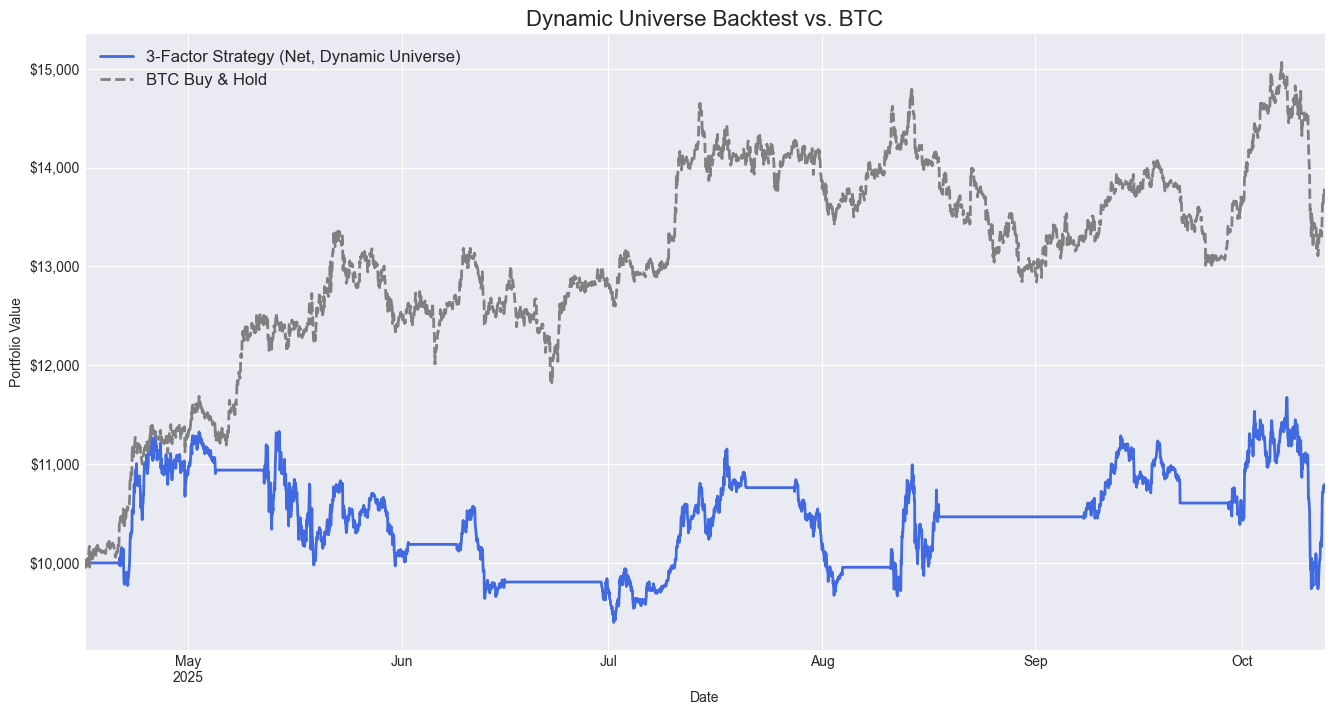

In [101]:
# ===========================================================================
# STEP 2 (NEW STRATEGY): RUN "TOP 3-FACTOR" BACKTEST WITH REGIME FILTER
# ===========================================================================

# --- A NEW "QUIET" FUNCTION FOR THE "TOP 3-FACTOR" STRATEGY ---
def generate_top_factor_signals(crypto_data, strategy_top_n=3):
    """
    Ranks all assets in the provided data slice by the 3-factor model and selects the top N.
    This is a pure momentum/quality strategy, not a dip-buying one.
    """
    if not crypto_data:
        return pd.DataFrame(), {}, []
        
    # Step 1: Rank all assets in the current universe using our original 3-factor model
    ranked_assets = rank_and_score_all_assets_quiet(crypto_data)
    
    if ranked_assets.empty:
        return pd.DataFrame(), {}, []

    # Step 2: Select the top N "quality/momentum" assets
    selected_symbols = ranked_assets.head(strategy_top_n).index.tolist()
    
    # Step 3: Calculate weights for the final selection
    position_weights = calculate_position_weights_quiet(crypto_data, selected_symbols)
    
    return ranked_assets, position_weights, selected_symbols


# --- NEW BACKTEST FUNCTION FOR THE "TOP 3-FACTOR" STRATEGY WITH REGIME FILTER ---
def run_backtest_simulation_top_factor_with_regime_filter(prices_df, backtest_crypto_data, market_caps_df, valid_symbols, btc_regime_filter_df, rebalance_freq='W-MON', rebalance_top_n=10, strategy_top_n=3):
    """
    Simulation loop that selects the top-ranked factor assets
    AND applies a BTC vs. 21-week EMA regime filter.
    """
    print("\nRunning 'Top 3-Factor' backtest with BTC Regime Filter...")
    weights_df = pd.DataFrame(0.0, index=prices_df.index, columns=valid_symbols)
    current_weights = pd.Series(0.0, index=valid_symbols)
    rebalance_dates = pd.date_range(start=prices_df.index.min(), end=prices_df.index.max(), freq=rebalance_freq)
    
    for date in prices_df.index:
        if date in rebalance_dates:
            # --- BTC REGIME FILTER CHECK ---
            try:
                is_bull_market = btc_regime_filter_df.loc[date, 'is_bullish']
            except KeyError:
                print(f"  Warning: No BTC regime data for {date.strftime('%Y-%m-%d')}. Defaulting to cash for safety.")
                is_bull_market = False # Default to safety if date is missing

            if is_bull_market:
                # --- BULL MARKET: Execute the top-factor strategy ---
                print(f"Rebalancing on {date.strftime('%Y-%m-%d')} (Market: Bullish)")
                active_universe = get_top_n_by_mcap_on_date(date, market_caps_df, n=rebalance_top_n)
                if not active_universe:
                    print(f"  No market cap data for {date.strftime('%Y-%m-%d')}. Holding previous weights.")
                else:
                    data_slice = {f"{s}/USDT": backtest_crypto_data[s].loc[:date] for s in active_universe if s in backtest_crypto_data}
                    try:
                        # --- Call the NEW top-factor function ---
                        _, position_weights, selected = generate_top_factor_signals(data_slice, strategy_top_n=strategy_top_n)
                        
                        if selected:
                            print(f"  -> Selected Top Factor Assets: {', '.join([s.split('/')[0] for s in selected])}")
                        else:
                            print("  -> No assets to select. Moving to cash.")

                        # Reset weights and update with new positions if any
                        current_weights = pd.Series(0.0, index=valid_symbols)
                        if position_weights:
                            cleaned_weights = {s.split('/')[0]: w for s, w in position_weights.items()}
                            current_weights.update(pd.Series(cleaned_weights))
                    except Exception as e:
                        print(f"  Error on rebalance day {date}: {e}. Holding previous weights.")
            else:
                # --- BEAR MARKET: Move to 100% cash ---
                print(f"Rebalancing on {date.strftime('%Y-%m-%d')} (Market: Bearish - BTC below 21w EMA). Moving to 100% cash.")
                current_weights = pd.Series(0.0, index=valid_symbols)
        
        weights_df.loc[date] = current_weights
    return weights_df


# --- PREPARE THE BTC REGIME FILTER (Unchanged) ---
print("Preparing BTC regime filter (21-week EMA)...")
# A 21-week EMA is approximately 21 * 7 = 147 days
EMA_PERIOD = 147 
btc_prices = prices_df['BTC']
btc_ema = btc_prices.ewm(span=EMA_PERIOD, adjust=False).mean()

# Create a DataFrame for easy lookup during the backtest
btc_regime_filter_df = pd.DataFrame({
    'BTC_Price': btc_prices,
    '21_Week_EMA': btc_ema
})
# The signal is True if the price is ABOVE the EMA
btc_regime_filter_df['is_bullish'] = btc_regime_filter_df['BTC_Price'] > btc_regime_filter_df['21_Week_EMA']
print("BTC regime filter prepared.")


# --- EXECUTE THE "TOP 3-FACTOR" BACKTEST WITH REGIME FILTER ---

# Run the new simulation logic
weights_df_tf_filtered = run_backtest_simulation_top_factor_with_regime_filter(
    prices_df=prices_df, 
    backtest_crypto_data=backtest_crypto_data, 
    market_caps_df=market_caps_df, 
    valid_symbols=valid_symbols, 
    btc_regime_filter_df=btc_regime_filter_df, # Pass the filter data
    rebalance_freq='W-MON', 
    rebalance_top_n=10,
    strategy_top_n=3
)

# Analyze and plot the results
final_metrics_tf_filtered = analyze_and_plot_results(
    weights_df=weights_df_tf_filtered, 
    returns_df=returns_df, 
    initial_capital=10000.0, 
    trading_fee=0.001, 
    slippage=0.0005, 
    benchmark_symbol='BTC'
)

Results are terrible! What if it's because the condition for longing is too strict? Instead, let's buy so long as BTC is above 3 week EMA?

## Trading Strategy 5: 3 facotr with 3-week BTC EMA filter

Preparing BTC regime filter (3-week EMA)...
BTC regime filter prepared.

Running 'Top 3-Factor' backtest with BTC Regime Filter...
Rebalancing on 2025-04-21 (Market: Bullish)
  -> Selected Top Factor Assets: LINK, XLM, SOL
Rebalancing on 2025-04-28 (Market: Bearish - BTC below 3w EMA). Moving to 100% cash.
Rebalancing on 2025-05-05 (Market: Bearish - BTC below 3w EMA). Moving to 100% cash.
Rebalancing on 2025-05-12 (Market: Bullish)
  -> Selected Top Factor Assets: ETH, DOGE, ADA
Rebalancing on 2025-05-19 (Market: Bullish)
  -> Selected Top Factor Assets: BTC, XRP, BNB
Rebalancing on 2025-05-26 (Market: Bullish)
  -> Selected Top Factor Assets: SOL, BNB, TRX
Rebalancing on 2025-06-02 (Market: Bullish)
  -> Selected Top Factor Assets: TRX, BNB, ETH
Rebalancing on 2025-06-09 (Market: Bearish - BTC below 3w EMA). Moving to 100% cash.
Rebalancing on 2025-06-16 (Market: Bullish)
  -> Selected Top Factor Assets: BCH, SOL, ETH
Rebalancing on 2025-06-23 (Market: Bullish)
  -> Selected Top Fact

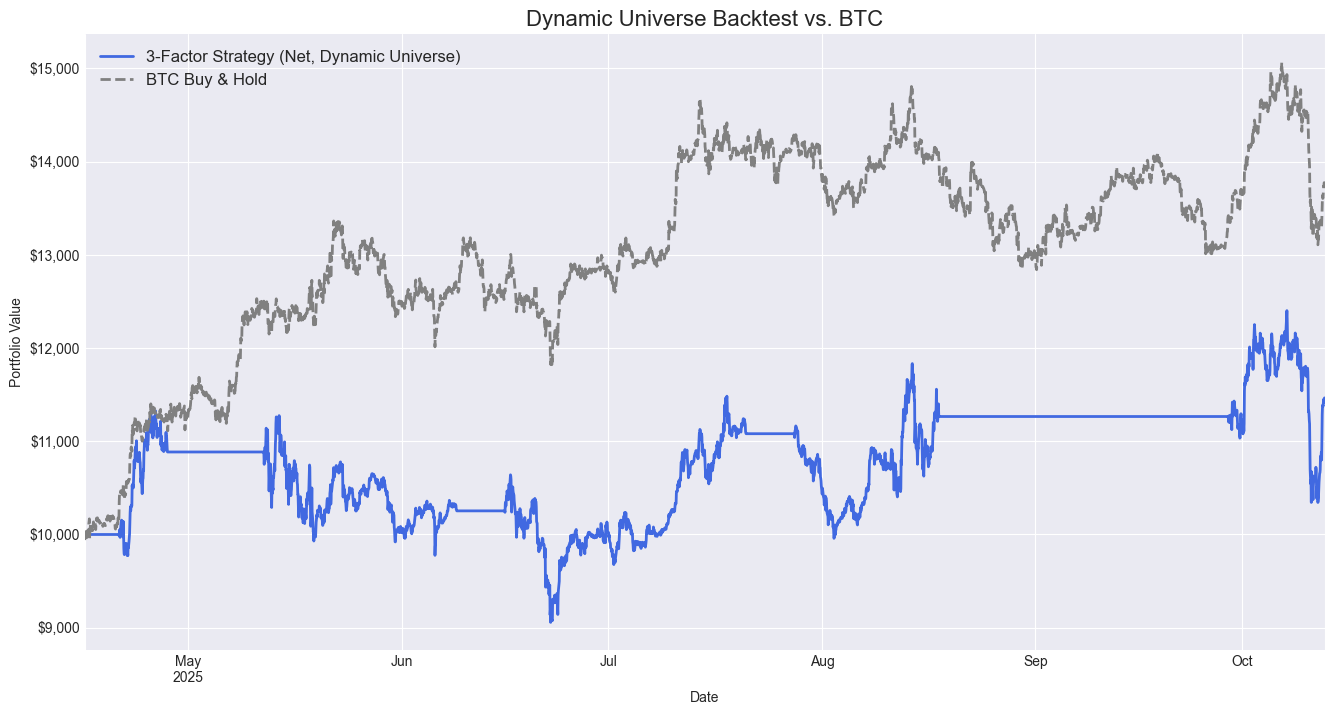

In [102]:
# ====================================================================================
# STEP 2 (NEW STRATEGY): RUN "TOP 3-FACTOR" BACKTEST WITH A 3-WEEK EMA REGIME FILTER
# ====================================================================================

# --- "QUIET" FUNCTION FOR THE "TOP 3-FACTOR" STRATEGY (Unchanged) ---
def generate_top_factor_signals(crypto_data, strategy_top_n=3):
    """
    Ranks all assets in the provided data slice by the 3-factor model and selects the top N.
    """
    if not crypto_data:
        return pd.DataFrame(), {}, []
        
    ranked_assets = rank_and_score_all_assets_quiet(crypto_data)
    
    if ranked_assets.empty:
        return pd.DataFrame(), {}, []

    selected_symbols = ranked_assets.head(strategy_top_n).index.tolist()
    position_weights = calculate_position_weights_quiet(crypto_data, selected_symbols)
    
    return ranked_assets, position_weights, selected_symbols


# --- BACKTEST FUNCTION FOR THE "TOP 3-FACTOR" STRATEGY WITH REGIME FILTER (Unchanged Logic, Updated Print Statement) ---
def run_backtest_simulation_top_factor_with_regime_filter(prices_df, backtest_crypto_data, market_caps_df, valid_symbols, btc_regime_filter_df, rebalance_freq='W-MON', rebalance_top_n=10, strategy_top_n=3):
    """
    Simulation loop that selects the top-ranked factor assets
    AND applies the provided BTC regime filter.
    """
    print("\nRunning 'Top 3-Factor' backtest with BTC Regime Filter...")
    weights_df = pd.DataFrame(0.0, index=prices_df.index, columns=valid_symbols)
    current_weights = pd.Series(0.0, index=valid_symbols)
    rebalance_dates = pd.date_range(start=prices_df.index.min(), end=prices_df.index.max(), freq=rebalance_freq)
    
    for date in prices_df.index:
        if date in rebalance_dates:
            try:
                is_bull_market = btc_regime_filter_df.loc[date, 'is_bullish']
            except KeyError:
                print(f"  Warning: No BTC regime data for {date.strftime('%Y-%m-%d')}. Defaulting to cash for safety.")
                is_bull_market = False

            if is_bull_market:
                print(f"Rebalancing on {date.strftime('%Y-%m-%d')} (Market: Bullish)")
                active_universe = get_top_n_by_mcap_on_date(date, market_caps_df, n=rebalance_top_n)
                if not active_universe:
                    print(f"  No market cap data for {date.strftime('%Y-%m-%d')}. Holding previous weights.")
                else:
                    data_slice = {f"{s}/USDT": backtest_crypto_data[s].loc[:date] for s in active_universe if s in backtest_crypto_data}
                    try:
                        _, position_weights, selected = generate_top_factor_signals(data_slice, strategy_top_n=strategy_top_n)
                        
                        if selected:
                            print(f"  -> Selected Top Factor Assets: {', '.join([s.split('/')[0] for s in selected])}")
                        else:
                            print("  -> No assets to select. Moving to cash.")

                        current_weights = pd.Series(0.0, index=valid_symbols)
                        if position_weights:
                            cleaned_weights = {s.split('/')[0]: w for s, w in position_weights.items()}
                            current_weights.update(pd.Series(cleaned_weights))
                    except Exception as e:
                        print(f"  Error on rebalance day {date}: {e}. Holding previous weights.")
            else:
                # Updated print statement for clarity
                print(f"Rebalancing on {date.strftime('%Y-%m-%d')} (Market: Bearish - BTC below 3w EMA). Moving to 100% cash.")
                current_weights = pd.Series(0.0, index=valid_symbols)
        
        weights_df.loc[date] = current_weights
    return weights_df


# --- UPDATED: PREPARE THE BTC REGIME FILTER (3-WEEK EMA) ---
print("Preparing BTC regime filter (3-week EMA)...")
# A 3-week EMA is approximately 3 * 7 = 21 days
EMA_PERIOD = 21 
btc_prices = prices_df['BTC']
btc_ema = btc_prices.ewm(span=EMA_PERIOD, adjust=False).mean()

# Create a DataFrame for easy lookup during the backtest
btc_regime_filter_df = pd.DataFrame({
    'BTC_Price': btc_prices,
    '3_Week_EMA': btc_ema  # Updated column name
})
# The signal is True if the price is ABOVE the EMA
btc_regime_filter_df['is_bullish'] = btc_regime_filter_df['BTC_Price'] > btc_regime_filter_df['3_Week_EMA']
print("BTC regime filter prepared.")


# --- EXECUTE THE "TOP 3-FACTOR" BACKTEST WITH THE 3-WEEK EMA REGIME FILTER ---

# Run the new simulation logic
weights_df_tf_filtered = run_backtest_simulation_top_factor_with_regime_filter(
    prices_df=prices_df, 
    backtest_crypto_data=backtest_crypto_data, 
    market_caps_df=market_caps_df, 
    valid_symbols=valid_symbols, 
    btc_regime_filter_df=btc_regime_filter_df, # Pass the new filter data
    rebalance_freq='W-MON', 
    rebalance_top_n=10,
    strategy_top_n=3
)

# Analyze and plot the results
final_metrics_tf_filtered = analyze_and_plot_results(
    weights_df=weights_df_tf_filtered, 
    returns_df=returns_df, 
    initial_capital=10000.0, 
    trading_fee=0.001, 
    slippage=0.0005, 
    benchmark_symbol='BTC'
)

Hmm performance was still terrible. Maybe now let's try adjusting the time horizon.

## Trading Strategy 6: Long only 3 factor model with fortnightly trades


Running 'Top 3-Factor Only' backtest with rebalance frequency: 2W-MON...
Rebalancing on 2025-04-28
  -> Selected Top Factor Assets: ETH, BTC, DOGE
Rebalancing on 2025-05-12
  -> Selected Top Factor Assets: ETH, DOGE, ADA
Rebalancing on 2025-05-26
  -> Selected Top Factor Assets: SOL, BNB, TRX
Rebalancing on 2025-06-09
  -> Selected Top Factor Assets: TRX, XRP, XLM
Rebalancing on 2025-06-23
  -> Selected Top Factor Assets: XRP, BTC, TRX
Rebalancing on 2025-07-07
  -> Selected Top Factor Assets: XLM, TRX, XRP
Rebalancing on 2025-07-21
  -> Selected Top Factor Assets: DOGE, ETH, BNB
Rebalancing on 2025-08-04
  -> Selected Top Factor Assets: TRX, XRP, XLM
Rebalancing on 2025-08-18
  -> Selected Top Factor Assets: ADA, BNB, TRX
Rebalancing on 2025-09-01
  -> Selected Top Factor Assets: SOL, BNB, BTC
Rebalancing on 2025-09-15
  -> Selected Top Factor Assets: DOGE, SOL, TRX
Rebalancing on 2025-09-29
  -> Selected Top Factor Assets: XLM, XRP, LINK
Rebalancing on 2025-10-13
  -> Selected Top F

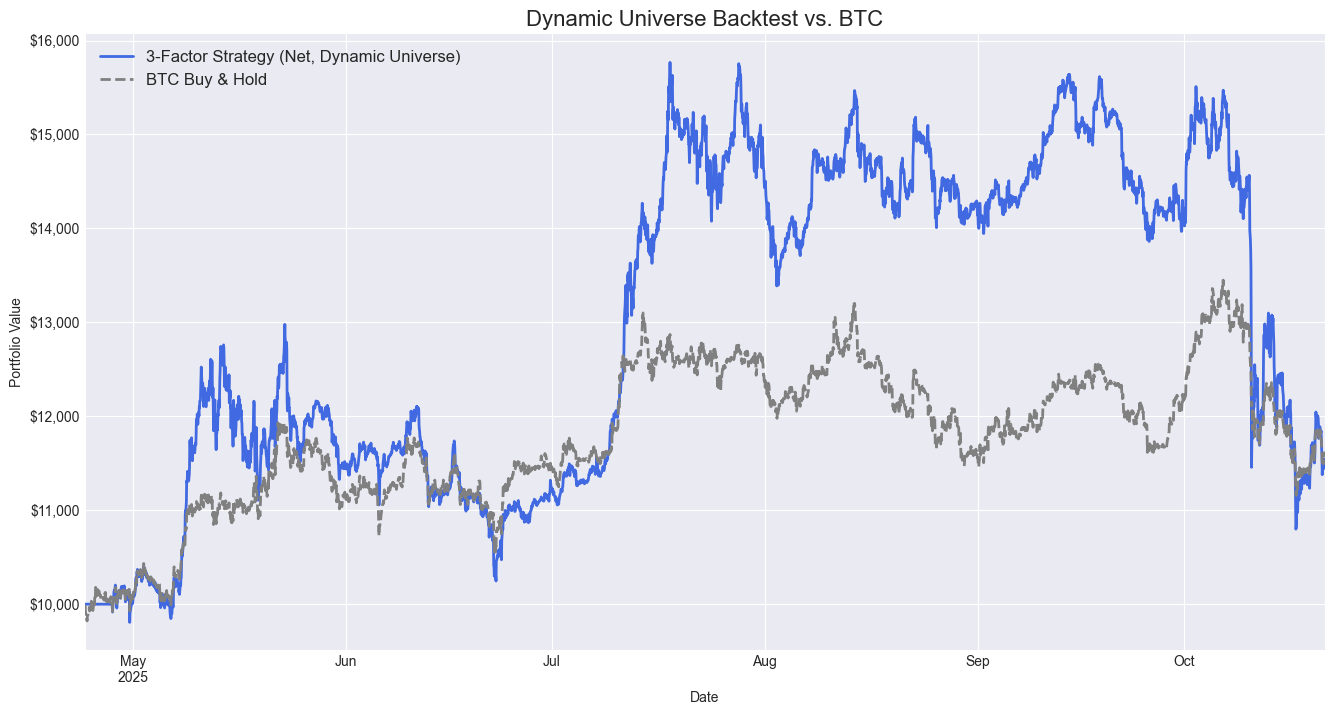

In [171]:
# ====================================================================================
# STEP 2 (NEW STRATEGY): RUN "TOP 3-FACTOR ONLY" BACKTEST (BI-WEEKLY REBALANCE)
# ====================================================================================

# --- "QUIET" FUNCTION FOR THE "TOP 3-FACTOR" STRATEGY (Unchanged) ---
def generate_top_factor_signals(crypto_data, strategy_top_n=3):
    """
    Ranks all assets in the provided data slice by the 3-factor model and selects the top N.
    """
    if not crypto_data:
        return pd.DataFrame(), {}, []
        
    ranked_assets = rank_and_score_all_assets_quiet(crypto_data)
    
    if ranked_assets.empty:
        return pd.DataFrame(), {}, []

    selected_symbols = ranked_assets.head(strategy_top_n).index.tolist()
    position_weights = calculate_position_weights_quiet(crypto_data, selected_symbols)
    
    return ranked_assets, position_weights, selected_symbols


# --- SIMPLIFIED BACKTEST FUNCTION (NO REGIME FILTER) (Unchanged) ---
def run_backtest_simulation_top_factor_only(prices_df, backtest_crypto_data, market_caps_df, valid_symbols, rebalance_freq='W-MON', rebalance_top_n=10, strategy_top_n=3):
    """
    Simplified simulation loop that is ALWAYS invested in the top-ranked factor assets.
    This version DOES NOT use a market regime filter.
    """
    # Updated print statement to be more generic about frequency
    print(f"\nRunning 'Top 3-Factor Only' backtest with rebalance frequency: {rebalance_freq}...")
    weights_df = pd.DataFrame(0.0, index=prices_df.index, columns=valid_symbols)
    current_weights = pd.Series(0.0, index=valid_symbols)
    rebalance_dates = pd.date_range(start=prices_df.index.min(), end=prices_df.index.max(), freq=rebalance_freq)
    
    for date in prices_df.index:
        if date in rebalance_dates:
            print(f"Rebalancing on {date.strftime('%Y-%m-%d')}")
            active_universe = get_top_n_by_mcap_on_date(date, market_caps_df, n=rebalance_top_n)
            if not active_universe:
                print(f"  No market cap data for {date.strftime('%Y-%m-%d')}. Holding previous weights.")
            else:
                data_slice = {f"{s}/USDT": backtest_crypto_data[s].loc[:date] for s in active_universe if s in backtest_crypto_data}
                try:
                    _, position_weights, selected = generate_top_factor_signals(data_slice, strategy_top_n=strategy_top_n)
                    
                    if selected:
                        print(f"  -> Selected Top Factor Assets: {', '.join([s.split('/')[0] for s in selected])}")
                    else:
                        print("  -> No assets to select. Moving to cash for this period.")

                    current_weights = pd.Series(0.0, index=valid_symbols)
                    if position_weights:
                        cleaned_weights = {s.split('/')[0]: w for s, w in position_weights.items()}
                        current_weights.update(pd.Series(cleaned_weights))
                except Exception as e:
                    print(f"  Error on rebalance day {date}: {e}. Holding previous weights.")
        
        weights_df.loc[date] = current_weights
    return weights_df


# --- EXECUTE THE "TOP 3-FACTOR ONLY" BACKTEST WITH BI-WEEKLY REBALANCING ---

# Run the new simulation logic with the updated bi-weekly frequency
weights_df_tf_only = run_backtest_simulation_top_factor_only(
    prices_df=prices_df, 
    backtest_crypto_data=backtest_crypto_data, 
    market_caps_df=market_caps_df, 
    valid_symbols=valid_symbols,
    rebalance_freq='2W-MON', # <-- CHANGED FROM 'W-MON' to '2W-MON'
    rebalance_top_n=10,
    strategy_top_n=3
)

# Analyze and plot the results
final_metrics_tf_only = analyze_and_plot_results(
    weights_df=weights_df_tf_only, 
    returns_df=returns_df, 
    initial_capital=10000.0, 
    trading_fee=0.001, 
    slippage=0.0005, 
    benchmark_symbol='BTC'
)

Given the recent market dip, we seem to have lost our alpha. This is probably due to the alt coins dropping much more than BTC during the recent correction.

This is meaningful data- this alpha is probably not going to work during market corrections.